In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

/tmp/ipykernel_406280/401849583.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
file = uproot.open("/nevis/riverside/data/isafa/MC/output_SBNOsc_NumuSelection_Modern_Uboone_Lite.root")
file.classnames()

{'totpot;1': 'TVectorT<double>',
 'tree_numu_cc;110': 'TTree',
 'tree_numu_cc;109': 'TTree',
 'tree_numu_nc;3': 'TTree',
 'tree_numu_nc;2': 'TTree',
 'tree_nue;1': 'TTree',
 'h_truth_size;1': 'TH1D',
 'reco_nc;1': 'TH1D',
 'reco_cc;1': 'TH1D',
 'reco_nue;1': 'TH1D',
 'stack_hist;1': 'TCanvas'}

In [3]:

file["totpot"].members
# this is the c++ way to see inside the data structure since the TVectorT doesn't have the keys, values, or iterable methods

{'fNrows': 1, 'fRowLwb': 0, 'fElements': array([1.13566344e+21], dtype='>f8')}

In [4]:
pot = file["totpot"].member("fElements")[0] 
#call the "fElements" member of the TVectorT class, then extract that array's first (and only) element
print(pot)

1.1356634398223269e+21


In [5]:
cc = file["tree_numu_cc"]
nc = file["tree_numu_nc"]

cc_reco_e = file["tree_numu_cc/reco_energy"].array(library="pd")
cc_true_e = file["tree_numu_cc/true_energy"].array(library="pd")
nc_true_e = file["tree_numu_nc/true_energy"].array(library="pd")
nc_reco_e = file["tree_numu_nc/reco_energy"].array(library="pd")

file["tree_numu_cc"].show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
reco_energy          | double                   | AsDtype('>f8')
true_energy          | double                   | AsDtype('>f8')
nu_pdg               | double                   | AsDtype('>f8')
true_baseline        | double                   | AsDtype('>f8')
weight               | double                   | AsDtype('>f8')
eventweights         | std::map<std::string,... | AsObjects(AsMap(True, AsStr...


Text(0.5, 1.0, 'NC Energies')

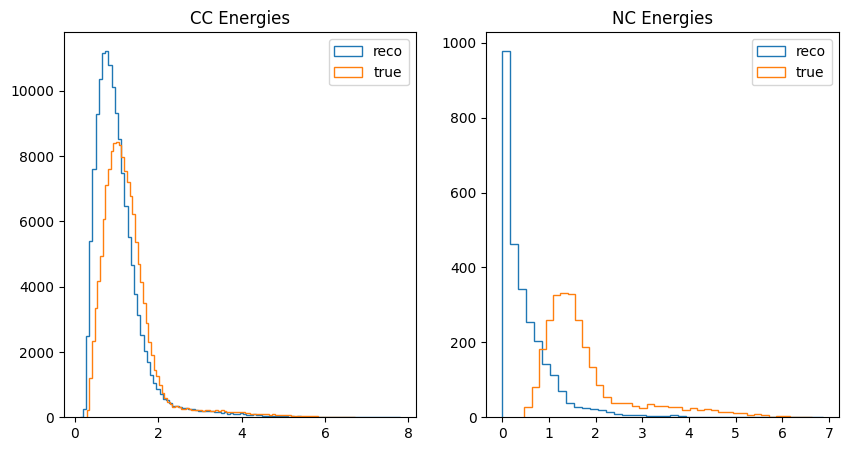

In [6]:
plt.figure(figsize=(10,5))
           
plt.subplot(121)
plt.hist(cc_reco_e, histtype="step", label="reco", bins=100)
plt.hist(cc_true_e, histtype="step", label="true", bins=100)
plt.legend()
plt.title("CC Energies")

plt.subplot(122)
plt.hist(nc_reco_e, histtype="step", label="reco", bins=40)
plt.hist(nc_true_e, histtype="step", label="true", bins=40)
plt.legend()
plt.title("NC Energies")

In [7]:
cc_pdgid = cc["nu_pdg"].array(library="pd")
nc_pdgid = nc["nu_pdg"].array(library="pd")

cc_weights = cc["weight"].array(library="pd")
nc_weights = nc["weight"].array(library="pd")

# doing our "final" weight calculation:
# weights = desired POT * simulated_weights / simulated_POT
des_pot = 1.2e+21
# using 1.2e21 as our desired POT as the ~total beam collected over microboone's lifetime
cc_calculated_weights = cc_weights *(des_pot / pot)
nc_calculated_weights = nc_weights *(des_pot / pot)

cc_true_baseline = cc["true_baseline"].array(library="pd")
nc_true_baseline = nc["true_baseline"].array(library="pd")

cc_pdgid.value_counts()
# 14 pdgid means muon neutrino
# -14 means muon antineutrino
# 12's would be electron neutrinos

 14.0    143494
-14.0      1255
Name: count, dtype: int64

In [8]:
#now find the oscillation probabilities and multiply them in as weights
thetas = [0,0.1,0.2,0.5,0.8,1,1.57,2,3.1]
deltam = 1 #10**(-4) #this is the delta_m^2 value (no need to also square it)

#these are the survival probabilities for the numus
cc_weight_arrays = []
nc_weight_arrays = []

for i in thetas:
    cc_osc_weights = 1 - ((np.sin(2*i))**2 * (np.sin(1.27 * deltam * (cc_true_baseline/1000) / cc_true_e))**2)
    nc_osc_weights = 1 - ((np.sin(2*i))**2 * (np.sin(1.27 * deltam * (nc_true_baseline/1000) / nc_true_e))**2)
    cc_weight_arrays.append(cc_osc_weights)
    nc_weight_arrays.append(nc_osc_weights)


In [9]:
np.arcsin(np.sqrt(0.003))/2

0.02739983945790986

NameError: name 'aaa' is not defined

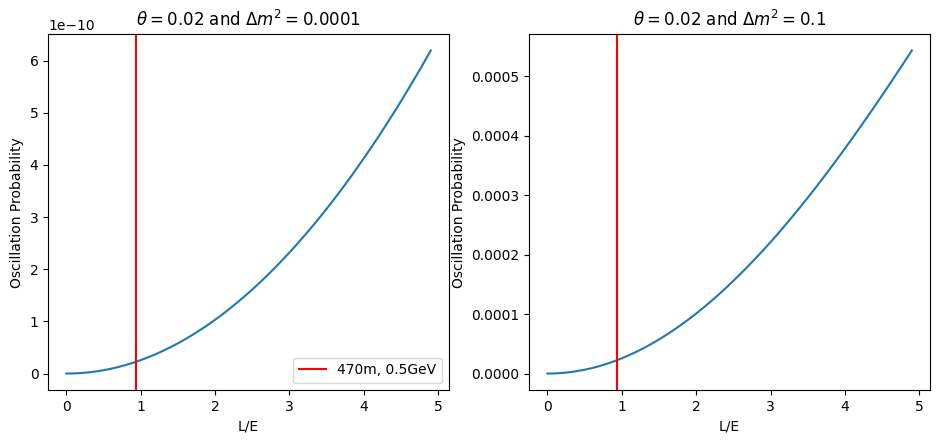

In [10]:
# muon to electron neutrino oscillation
def prob_energy(theta, deltm, L_E):
    probab = ((np.sin(2*theta))**2 * (np.sin(1.27*deltm*L_E))**2)
    return(probab)

d = np.arange(5, step=0.1)
thetas = [0.02, 0.027, 0.05, 0.1, 0.15, 0.2, 0.5, 0.8, 1, 1.57, 2]
delts = [10**(-4),0.1,1.2,2.7,10]

plt.figure(figsize=(30,60))
n = 1
for i in thetas:
    for j in delts:
        vals = prob_energy(i, j, d)
        
        plt.subplot(11, 5, n)
        plt.plot(d,vals)
        plt.xlabel("L/E")
        plt.ylabel("Oscillation Probability")
        plt.axvline(0.47/.5, label="470m, 0.5GeV", color="red")
        title = "$\\theta=$" + str(i) + " and $\\Delta{m}^2=$" + str(j)
        plt.title(title)
        
        if(j==0.1):
            plt.plot(aaa, aa, label="e_osc_0.1")
        elif(j==1.2):
            plt.plot(bbb,bb, label="e_osc_1.2")
        elif(j==2.7):
            plt.plot(ccc,cc,label="e_osc_2.7")
        elif(j==10):
            plt.plot(ddd,dd,label="e_osc_10")
        plt.legend()
        n=n+1
        

In [11]:
cc_vals = pd.concat((cc_pdgid,cc_reco_e,cc_true_e,cc_true_baseline,cc_weights,cc_calculated_weights,cc_weight_arrays[0],cc_weight_arrays[1],cc_weight_arrays[2],cc_weight_arrays[3],cc_weight_arrays[4],cc_weight_arrays[5],cc_weight_arrays[6], cc_weight_arrays[7], cc_weight_arrays[8]), axis=1)
cc_vals.columns = ["pdgid","cc_reco_e","cc_true_e","cc_true_baseline","weight","final_weight","osc_weight_0","osc_weight_0.1","osc_weight_0.2","osc_weight_0.5","osc_weight_0.8","osc_weight_1","osc_weight_1.57","osc_weight_2","osc_weight_3.1"]

nc_vals = pd.concat((nc_pdgid,nc_reco_e,nc_true_e,nc_true_baseline,nc_weights,nc_calculated_weights,nc_weight_arrays[0],nc_weight_arrays[1],nc_weight_arrays[2],nc_weight_arrays[3],nc_weight_arrays[4],nc_weight_arrays[5],nc_weight_arrays[6],nc_weight_arrays[7],nc_weight_arrays[8]), axis=1)
nc_vals.columns = ["pdgid","nc_reco_e","nc_true_e","nc_true_baseline","weight","final_weight","osc_weight_0","osc_weight_0.1","osc_weight_0.2","osc_weight_0.5","osc_weight_0.8","osc_weight_1","osc_weight_1.57","osc_weight_2","osc_weight_3.1"]

cc_vals

,pdgid,cc_reco_e,cc_true_e,cc_true_baseline,weight,final_weight,osc_weight_0,osc_weight_0.1,osc_weight_0.2,osc_weight_0.5,osc_weight_0.8,osc_weight_1,osc_weight_1.57,osc_weight_2,osc_weight_3.1
0,14.0,1.711828,1.757892,421.313934,0.783403,0.827783,1.0,0.996455,0.986379,0.936400,0.910255,0.925734,1.000000,0.948555,0.999380
1,14.0,0.529436,0.549600,424.480774,0.795545,0.840614,1.0,0.972745,0.895282,0.511049,0.310052,0.429049,0.999998,0.604495,0.995233
2,14.0,0.974645,3.674724,459.963684,0.762876,0.806094,1.0,0.999011,0.996200,0.982257,0.974964,0.979282,1.000000,0.985648,0.999827
3,14.0,0.361605,0.770172,462.815247,0.796858,0.842001,1.0,0.981142,0.927546,0.661694,0.522624,0.604958,0.999999,0.726349,0.996701
4,14.0,0.686827,1.015526,444.881378,0.744325,0.786492,1.0,0.988992,0.957707,0.802526,0.721348,0.769408,0.999999,0.840266,0.998075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144744,14.0,0.731161,0.761160,438.133759,0.796858,0.842001,1.0,0.982407,0.932405,0.684385,0.554643,0.631455,0.999999,0.744704,0.996923
144745,14.0,1.039197,1.252841,435.704590,0.793956,0.838934,1.0,0.992788,0.972292,0.870625,0.817441,0.848927,1.000000,0.895350,0.998739
144746,14.0,0.635204,0.679644,461.725922,0.790720,0.835515,1.0,0.977223,0.912487,0.591381,0.423406,0.522853,0.999999,0.669474,0.996016
144747,14.0,0.687865,0.963325,424.912109,0.792902,0.837821,1.0,0.988857,0.957187,0.800094,0.717917,0.766569,0.999999,0.838299,0.998051


In [12]:
cc_nu_u = cc_vals[(cc_vals["pdgid"]==14.0)]
cc_nu_a = cc_vals[(cc_vals["pdgid"]==-14.0)]

nc_nu_u = nc_vals[(nc_vals["pdgid"]==14.0)]
nc_nu_a = nc_vals[(nc_vals["pdgid"]==-14.0)]

Text(0.6, 15.5, 'POT = 1.2e21')

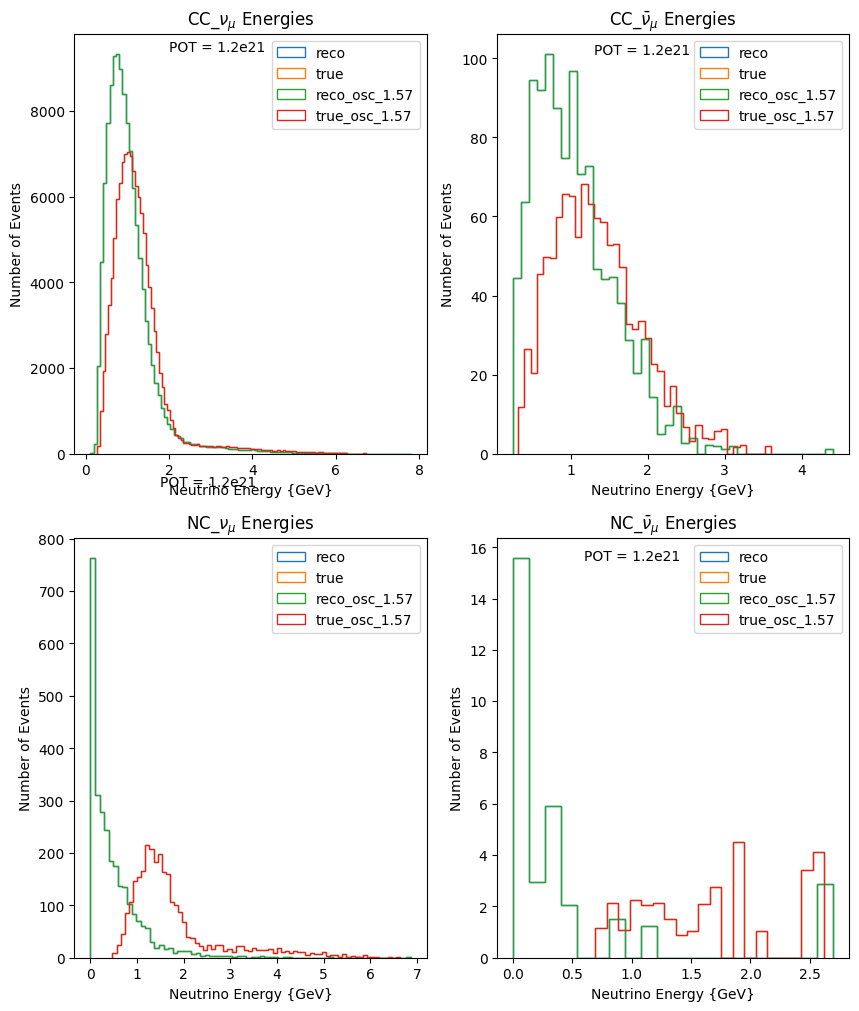

In [13]:
plt.figure(figsize=(10,12))

plt.subplot(221)
plt.hist(cc_nu_u["cc_reco_e"], histtype="step", label="reco", bins=100, weights=cc_nu_u["final_weight"])
plt.hist(cc_nu_u["cc_true_e"], histtype="step", label="true", bins=100, weights=cc_nu_u["final_weight"])
plt.hist(cc_nu_u["cc_reco_e"], histtype="step", label="reco_osc_1.57", bins=100, weights=(cc_nu_u["final_weight"]*cc_nu_u["osc_weight_1.57"]))
plt.hist(cc_nu_u["cc_true_e"], histtype="step", label="true_osc_1.57", bins=100, weights=(cc_nu_u["final_weight"]*cc_nu_u["osc_weight_1.57"]))
plt.legend()
plt.title("CC_$\\nu_{\mu}$ Energies")
plt.xlabel("Neutrino Energy {GeV}")
plt.ylabel("Number of Events")
plt.text(2,9400,"POT = 1.2e21")
                 
plt.subplot(222)
plt.hist(cc_nu_a["cc_reco_e"], histtype="step", label="reco", bins=40, weights=cc_nu_a["final_weight"])
plt.hist(cc_nu_a["cc_true_e"], histtype="step", label="true", bins=40, weights=cc_nu_a["final_weight"])
plt.hist(cc_nu_a["cc_reco_e"], histtype="step", label="reco_osc_1.57", bins=40, weights=(cc_nu_a["final_weight"]*cc_nu_a["osc_weight_1.57"]))
plt.hist(cc_nu_a["cc_true_e"], histtype="step", label="true_osc_1.57", bins=40, weights=(cc_nu_a["final_weight"]*cc_nu_a["osc_weight_1.57"]))
plt.legend()
plt.title("CC_$\\bar{\\nu}_{\mu}$ Energies")
plt.xlabel("Neutrino Energy {GeV}")
plt.ylabel("Number of Events")
plt.text(1.3,101,"POT = 1.2e21")

plt.subplot(223)
plt.hist(nc_nu_u["nc_reco_e"], histtype="step", label="reco", bins=70, weights=nc_nu_u["final_weight"])
plt.hist(nc_nu_u["nc_true_e"], histtype="step", label="true", bins=70, weights=nc_nu_u["final_weight"])
plt.hist(nc_nu_u["nc_reco_e"], histtype="step", label="reco_osc_1.57", bins=70, weights=(nc_nu_u["final_weight"]*nc_nu_u["osc_weight_1.57"]))
plt.hist(nc_nu_u["nc_true_e"], histtype="step", label="true_osc_1.57", bins=70, weights=(nc_nu_u["final_weight"]*nc_nu_u["osc_weight_1.57"]))
plt.legend()
plt.title("NC_$\\nu_{\mu}$ Energies")
plt.xlabel("Neutrino Energy {GeV}")
plt.ylabel("Number of Events")
plt.text(1.5,900,"POT = 1.2e21")
                 
plt.subplot(224)
plt.hist(nc_nu_a["nc_reco_e"], histtype="step", label="reco", bins=20, weights=nc_nu_a["final_weight"])
plt.hist(nc_nu_a["nc_true_e"], histtype="step", label="true", bins=20, weights=nc_nu_a["final_weight"])
plt.hist(nc_nu_a["nc_reco_e"], histtype="step", label="reco_osc_1.57", bins=20, weights=(nc_nu_a["final_weight"]*nc_nu_a["osc_weight_1.57"]))
plt.hist(nc_nu_a["nc_true_e"], histtype="step", label="true_osc_1.57", bins=20, weights=(nc_nu_a["final_weight"]*nc_nu_a["osc_weight_1.57"]))
plt.legend()
plt.title("NC_$\\bar{\\nu}_{\mu}$ Energies")
plt.xlabel("Neutrino Energy {GeV}")
plt.ylabel("Number of Events")
plt.text(0.6,15.5,"POT = 1.2e21")

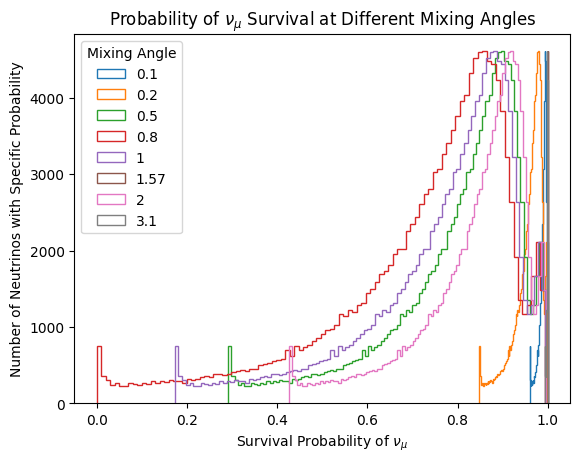

In [14]:
plt.hist(cc_nu_u["osc_weight_0.1"], label="0.1", histtype="step", bins=100)
plt.hist(cc_nu_u["osc_weight_0.2"], label="0.2", histtype="step", bins=100)
plt.hist(cc_nu_u["osc_weight_0.5"], label="0.5", histtype="step", bins=100)
plt.hist(cc_nu_u["osc_weight_0.8"], label="0.8", histtype="step", bins=100)
plt.hist(cc_nu_u["osc_weight_1"], label="1", histtype="step", bins=100)
plt.hist(cc_nu_u["osc_weight_1.57"], label="1.57", histtype="step", bins=100)
plt.hist(cc_nu_u["osc_weight_2"], label="2", histtype="step", bins=100)
plt.hist(cc_nu_u["osc_weight_3.1"], label="3.1", histtype="step", bins=100)
plt.title("Probability of $\\nu_{\mu}$ Survival at Different Mixing Angles")
plt.xlabel("Survival Probability of $\\nu_{\mu}$")
plt.ylabel("Number of Neutrinos with Specific Probability")
#plt.text(0.954,9900, "$\Delta M^2 = 10^{-4}$")
plt.legend(title="Mixing Angle")

In [15]:
#look at other files
file2 = uproot.open("/nevis/riverside/data/isafa/MC/output_SBNOsc_NueSelection_Modern_UBOONE_Numu_Lite.root")
file3 = uproot.open("/nevis/riverside/data/isafa/MC/output_SBNOsc_NueSelection_Modern_UBOONE_Nu_Osc_Lite.root") 
file4 = uproot.open("/nevis/riverside/data/isafa/MC/output_SBNOsc_NueSelection_Modern_UBOONE_Intrinsic_Nue_Lite.root")

In [16]:
file2.classnames()

{'totpot;1': 'TVectorT<double>',
 'simpletree;3': 'TTree',
 'simpletree;2': 'TTree',
 'reco_energy;1': 'TH1D',
 'h_truthsize;1': 'TH1D'}

In [17]:
file2["simpletree"].show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
reco_energy          | double                   | AsDtype('>f8')
true_energy          | double                   | AsDtype('>f8')
nu_pdg               | double                   | AsDtype('>f8')
true_baseline        | double                   | AsDtype('>f8')
weight               | double                   | AsDtype('>f8')
eventweights         | std::map<std::string,... | AsObjects(AsMap(True, AsStr...


In [18]:
pot2 = file2["totpot"].member("fElements")[0]
pot3 = file3["totpot"].member("fElements")[0]
pot4 = file4["totpot"].member("fElements")[0]

In [19]:
Nue_Numu = file2["simpletree"].arrays(["reco_energy","true_energy","nu_pdg","true_baseline","weight"], library="pd")
Nue_NuOsc = file3["simpletree"].arrays(["reco_energy","true_energy","nu_pdg","true_baseline","weight"], library="pd")
Nue_Intrinsic = file4["simpletree"].arrays(["reco_energy","true_energy","nu_pdg","true_baseline","weight"], library="pd")

In [20]:
Nue_Numu["pot_weight"] = Nue_Numu["weight"] * (des_pot / pot2)
Nue_NuOsc["pot_weight"] = Nue_NuOsc["weight"] * (des_pot / pot3)
Nue_Intrinsic["pot_weight"] = Nue_Intrinsic["weight"] * (des_pot / pot4)

In [21]:
Nue_Intrinsic["nu_pdg"].value_counts()

nu_pdg
 12.0    137527
-12.0      4455
Name: count, dtype: int64

In [22]:
sin2_mumu = 0.1
sin2_ee = 0.1
sin2_mue = 0.003

deltms = [0.1, 1.2, 2.7, 10]

In [23]:
#the survival of initial electron neutrinos in detector (lost some to e->mu osc)
Nue_Intrinsic["ee_osc_0.1"] = 1 - ((sin2_ee)*(np.sin(1.27*deltms[0]*(Nue_Intrinsic["true_baseline"]/1000)/Nue_Intrinsic["true_energy"]))**2)
Nue_Intrinsic["ee_osc_1.2"] = 1 - ((sin2_ee)*(np.sin(1.27*deltms[1]*(Nue_Intrinsic["true_baseline"]/1000)/Nue_Intrinsic["true_energy"]))**2)
Nue_Intrinsic["ee_osc_2.7"] = 1 - ((sin2_ee)*(np.sin(1.27*deltms[2]*(Nue_Intrinsic["true_baseline"]/1000)/Nue_Intrinsic["true_energy"]))**2)
Nue_Intrinsic["ee_osc_10"] = 1 - ((sin2_ee)*(np.sin(1.27*deltms[3]*(Nue_Intrinsic["true_baseline"]/1000)/Nue_Intrinsic["true_energy"]))**2)

In [24]:
Nue_Intrinsic

,reco_energy,true_energy,nu_pdg,true_baseline,weight,pot_weight,ee_osc_0.1,ee_osc_1.2,ee_osc_2.7,ee_osc_10
0,0.923315,0.876059,12.0,440.938934,0.8,0.005147,0.999592,0.951833,0.902386,0.998817
1,1.362947,1.371606,12.0,419.937988,0.8,0.005147,0.999849,0.979764,0.924771,0.953865
2,0.767507,0.945759,12.0,456.666046,0.8,0.005147,0.999624,0.954944,0.900719,0.997740
3,0.969170,1.224530,12.0,456.922424,0.8,0.005147,0.999776,0.971001,0.908248,0.900070
4,1.053085,1.045812,12.0,424.669800,0.8,0.005147,0.999734,0.966349,0.903149,0.918503
...,...,...,...,...,...,...,...,...,...,...
141977,1.214176,1.287920,12.0,461.427307,0.8,0.005147,0.999793,0.973035,0.911265,0.902612
141978,0.391194,1.161591,12.0,439.463531,0.8,0.005147,0.999769,0.970281,0.907296,0.900851
141979,0.914526,0.891304,12.0,424.930573,0.8,0.005147,0.999634,0.955869,0.900409,0.994871
141980,2.312864,2.029602,12.0,455.294495,0.8,0.005147,0.999919,0.988761,0.951618,0.991678


In [25]:
#the appearance of electron neutrinos from mu->e osc
Nue_NuOsc["mue_osc_0.1"] = sin2_mue * (np.sin(1.27*deltms[0]*(Nue_NuOsc["true_baseline"]/1000)/Nue_NuOsc["true_energy"]))**2
Nue_NuOsc["mue_osc_1.2"] = sin2_mue * (np.sin(1.27*deltms[1]*(Nue_NuOsc["true_baseline"]/1000)/Nue_NuOsc["true_energy"]))**2
Nue_NuOsc["mue_osc_2.7"] = sin2_mue * (np.sin(1.27*deltms[2]*(Nue_NuOsc["true_baseline"]/1000)/Nue_NuOsc["true_energy"]))**2
Nue_NuOsc["mue_osc_10"] = sin2_mue * (np.sin(1.27*deltms[3]*(Nue_NuOsc["true_baseline"]/1000)/Nue_NuOsc["true_energy"]))**2

In [26]:
Nue_NuOsc

,reco_energy,true_energy,nu_pdg,true_baseline,weight,pot_weight,mue_osc_0.1,mue_osc_1.2,mue_osc_2.7,mue_osc_10
0,1.213114,1.496588,12.0,462.181458,0.8,0.805185,0.000005,0.000617,0.002280,0.001485
1,0.432837,0.525711,12.0,448.144012,0.8,0.805185,0.000035,0.002784,0.000141,0.002915
2,1.414220,1.549919,12.0,432.758240,0.8,0.805185,0.000004,0.000511,0.002006,0.000464
3,1.332612,1.510953,12.0,453.108093,0.8,0.805185,0.000004,0.000584,0.002200,0.001148
4,1.508633,1.862239,12.0,428.752655,0.8,0.805185,0.000003,0.000354,0.001512,0.000140
...,...,...,...,...,...,...,...,...,...,...
150684,0.569495,1.049381,12.0,470.279938,0.8,0.805185,0.000010,0.001195,0.002997,0.000933
150685,0.645647,0.725496,12.0,453.229614,0.8,0.805185,0.000019,0.001991,0.002123,0.002981
150686,1.218402,1.234121,12.0,436.140656,0.8,0.805185,0.000006,0.000789,0.002630,0.002852
150687,1.144119,0.975885,12.0,429.831512,0.8,0.805185,0.000009,0.001161,0.002989,0.001214


Text(0, 0.5, 'Number of Events')

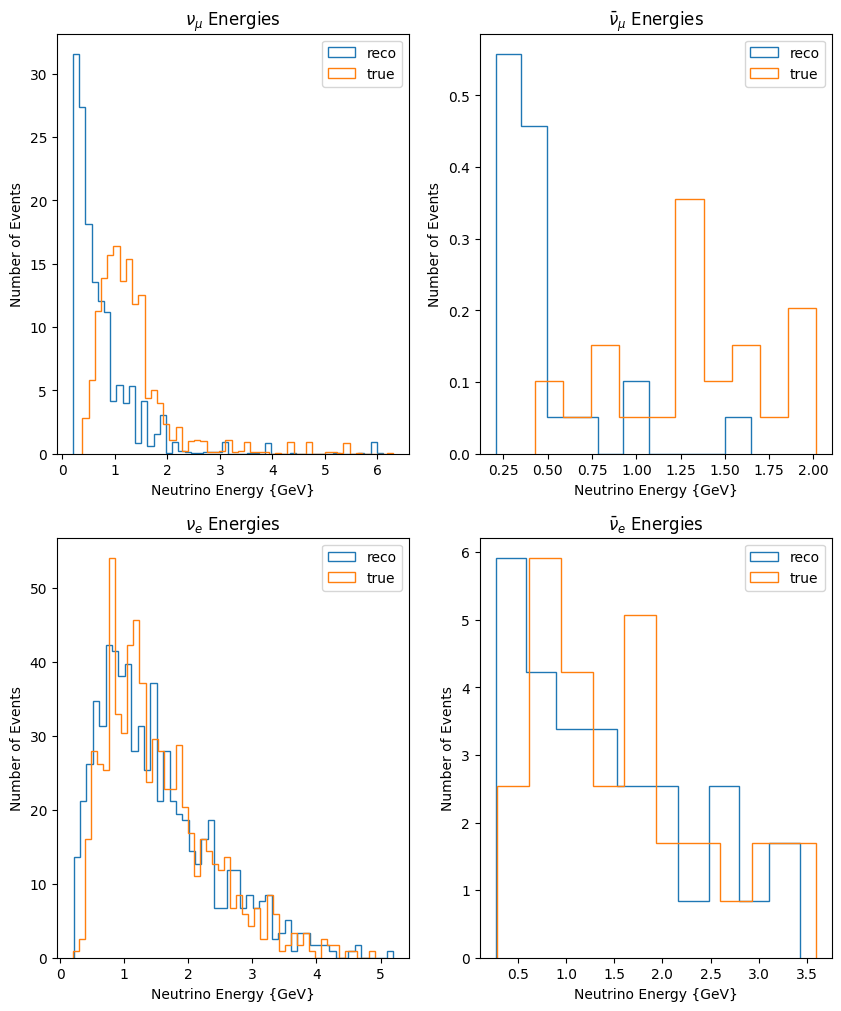

In [27]:
# Nue_Numu plots
plt.figure(figsize=(10,12))

plt.subplot(221)
plt.hist(Nue_Numu["reco_energy"][(Nue_Numu["nu_pdg"] == 14.0)], histtype="step", label="reco", bins=50, weights=Nue_Numu["pot_weight"][(Nue_Numu["nu_pdg"] == 14.0)])
plt.hist(Nue_Numu["true_energy"][(Nue_Numu["nu_pdg"] == 14.0)], histtype="step", label="true", bins=50, weights=Nue_Numu["pot_weight"][(Nue_Numu["nu_pdg"] == 14.0)])
plt.legend()
plt.title("$\\nu_{\mu}$ Energies")
plt.xlabel("Neutrino Energy {GeV}")
plt.ylabel("Number of Events")
#plt.text(3,9400,"POT = 1.2e21")
                 
plt.subplot(222)
plt.hist(Nue_Numu["reco_energy"][(Nue_Numu["nu_pdg"] == -14.0)], histtype="step", label="reco", bins=10, weights=Nue_Numu["pot_weight"][(Nue_Numu["nu_pdg"] == -14.0)])
plt.hist(Nue_Numu["true_energy"][(Nue_Numu["nu_pdg"] == -14.0)], histtype="step", label="true", bins=10, weights=Nue_Numu["pot_weight"][(Nue_Numu["nu_pdg"] == -14.0)])
plt.legend()
plt.title("$\\bar{\\nu}_{\mu}$ Energies")
plt.xlabel("Neutrino Energy {GeV}")
plt.ylabel("Number of Events")
#plt.text(1.8,101,"POT = 1.2e21")

plt.subplot(223)
plt.hist(Nue_Numu["reco_energy"][(Nue_Numu["nu_pdg"] == 12.0)], histtype="step", label="reco", bins=50, weights=Nue_Numu["pot_weight"][(Nue_Numu["nu_pdg"] == 12.0)])
plt.hist(Nue_Numu["true_energy"][(Nue_Numu["nu_pdg"] == 12.0)], histtype="step", label="true", bins=50, weights=Nue_Numu["pot_weight"][(Nue_Numu["nu_pdg"] == 12.0)])
plt.legend()
plt.title("$\\nu_{e}$ Energies")
plt.xlabel("Neutrino Energy {GeV}")
plt.ylabel("Number of Events")
#plt.text(2.5,900,"POT = 1.2e21")
                 
plt.subplot(224)
plt.hist(Nue_Numu["reco_energy"][(Nue_Numu["nu_pdg"] == -12.0)], histtype="step", label="reco", bins=10, weights=Nue_Numu["pot_weight"][(Nue_Numu["nu_pdg"] == -12.0)])
plt.hist(Nue_Numu["true_energy"][(Nue_Numu["nu_pdg"] == -12.0)], histtype="step", label="true", bins=10, weights=Nue_Numu["pot_weight"][(Nue_Numu["nu_pdg"] == -12.0)])
plt.legend()
plt.title("$\\bar{\\nu}_{e}$ Energies")
plt.xlabel("Neutrino Energy {GeV}")
plt.ylabel("Number of Events")
#plt.text(0.9,15.5,"POT = 1.2e21")

In [28]:
Nue_NuOsc

,reco_energy,true_energy,nu_pdg,true_baseline,weight,pot_weight,mue_osc_0.1,mue_osc_1.2,mue_osc_2.7,mue_osc_10
0,1.213114,1.496588,12.0,462.181458,0.8,0.805185,0.000005,0.000617,0.002280,0.001485
1,0.432837,0.525711,12.0,448.144012,0.8,0.805185,0.000035,0.002784,0.000141,0.002915
2,1.414220,1.549919,12.0,432.758240,0.8,0.805185,0.000004,0.000511,0.002006,0.000464
3,1.332612,1.510953,12.0,453.108093,0.8,0.805185,0.000004,0.000584,0.002200,0.001148
4,1.508633,1.862239,12.0,428.752655,0.8,0.805185,0.000003,0.000354,0.001512,0.000140
...,...,...,...,...,...,...,...,...,...,...
150684,0.569495,1.049381,12.0,470.279938,0.8,0.805185,0.000010,0.001195,0.002997,0.000933
150685,0.645647,0.725496,12.0,453.229614,0.8,0.805185,0.000019,0.001991,0.002123,0.002981
150686,1.218402,1.234121,12.0,436.140656,0.8,0.805185,0.000006,0.000789,0.002630,0.002852
150687,1.144119,0.975885,12.0,429.831512,0.8,0.805185,0.000009,0.001161,0.002989,0.001214


Text(0, 0.5, 'Number of Events')

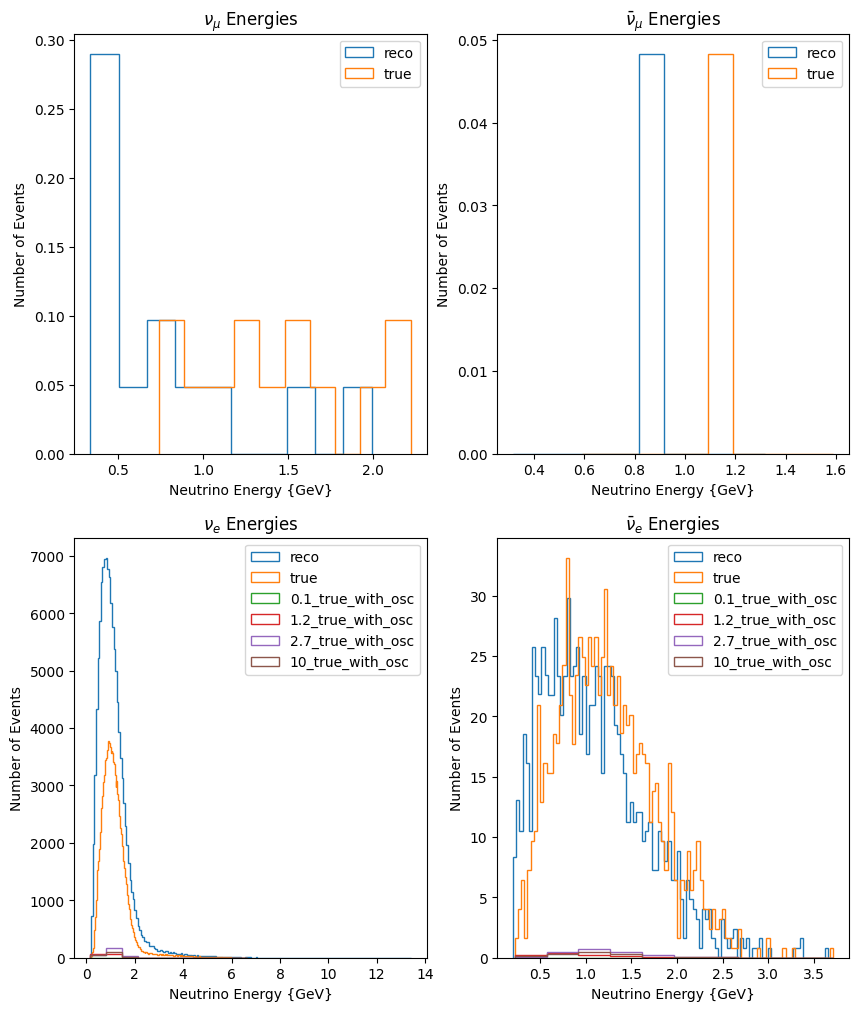

In [29]:
# Nue_NuOsc plots
plt.figure(figsize=(10,12))

plt.subplot(221)
plt.hist(Nue_NuOsc["reco_energy"][(Nue_NuOsc["nu_pdg"] == 14.0)], histtype="step", label="reco", bins=10, weights=Nue_NuOsc["pot_weight"][(Nue_NuOsc["nu_pdg"] == 14.0)])
plt.hist(Nue_NuOsc["true_energy"][(Nue_NuOsc["nu_pdg"] == 14.0)], histtype="step", label="true", bins=10, weights=Nue_NuOsc["pot_weight"][(Nue_NuOsc["nu_pdg"] == 14.0)])
plt.legend()
plt.title("$\\nu_{\mu}$ Energies")
plt.xlabel("Neutrino Energy {GeV}")
plt.ylabel("Number of Events")
#plt.text(3,9400,"POT = 1.2e21")
                 
plt.subplot(222)
plt.hist(Nue_NuOsc["reco_energy"][(Nue_NuOsc["nu_pdg"] == -14.0)], histtype="step", label="reco", bins=10, weights=Nue_NuOsc["pot_weight"][(Nue_NuOsc["nu_pdg"] == -14.0)])
plt.hist(Nue_NuOsc["true_energy"][(Nue_NuOsc["nu_pdg"] == -14.0)], histtype="step", label="true", bins=10, weights=Nue_NuOsc["pot_weight"][(Nue_NuOsc["nu_pdg"] == -14.0)])
plt.legend()
plt.title("$\\bar{\\nu}_{\mu}$ Energies")
plt.xlabel("Neutrino Energy {GeV}")
plt.ylabel("Number of Events")
#plt.text(1.8,101,"POT = 1.2e21")

plt.subplot(223)
plt.hist(Nue_NuOsc["reco_energy"][(Nue_NuOsc["nu_pdg"] == 12.0)], histtype="step", label="reco", bins=200, weights=Nue_NuOsc["pot_weight"][(Nue_NuOsc["nu_pdg"] == 12.0)])
plt.hist(Nue_NuOsc["true_energy"][(Nue_NuOsc["nu_pdg"] == 12.0)], histtype="step", label="true", bins=200, weights=Nue_NuOsc["pot_weight"][(Nue_NuOsc["nu_pdg"] == 12.0)])
plt.hist(Nue_NuOsc["true_energy"][(Nue_NuOsc["nu_pdg"] == 12.0)], histtype="step", label="0.1_true_with_osc", bins=10, weights=(Nue_NuOsc["pot_weight"][(Nue_NuOsc["nu_pdg"] == 12.0)])*(Nue_NuOsc["mue_osc_0.1"][(Nue_NuOsc["nu_pdg"] == 12.0)]))
plt.hist(Nue_NuOsc["true_energy"][(Nue_NuOsc["nu_pdg"] == 12.0)], histtype="step", label="1.2_true_with_osc", bins=10, weights=(Nue_NuOsc["pot_weight"][(Nue_NuOsc["nu_pdg"] == 12.0)])*(Nue_NuOsc["mue_osc_1.2"][(Nue_NuOsc["nu_pdg"] == 12.0)]))
plt.hist(Nue_NuOsc["true_energy"][(Nue_NuOsc["nu_pdg"] == 12.0)], histtype="step", label="2.7_true_with_osc", bins=10, weights=(Nue_NuOsc["pot_weight"][(Nue_NuOsc["nu_pdg"] == 12.0)])*(Nue_NuOsc["mue_osc_2.7"][(Nue_NuOsc["nu_pdg"] == 12.0)]))
plt.hist(Nue_NuOsc["true_energy"][(Nue_NuOsc["nu_pdg"] == 12.0)], histtype="step", label="10_true_with_osc", bins=10, weights=(Nue_NuOsc["pot_weight"][(Nue_NuOsc["nu_pdg"] == 12.0)])*(Nue_NuOsc["mue_osc_10"][(Nue_NuOsc["nu_pdg"] == 12.0)]))
plt.legend()
plt.title("$\\nu_{e}$ Energies")
plt.xlabel("Neutrino Energy {GeV}")
plt.ylabel("Number of Events")
#plt.text(2.5,900,"POT = 1.2e21")
                 
plt.subplot(224)
plt.hist(Nue_NuOsc["reco_energy"][(Nue_NuOsc["nu_pdg"] == -12.0)], histtype="step", label="reco", bins=100, weights=Nue_NuOsc["pot_weight"][(Nue_NuOsc["nu_pdg"] == -12.0)])
plt.hist(Nue_NuOsc["true_energy"][(Nue_NuOsc["nu_pdg"] == -12.0)], histtype="step", label="true", bins=100, weights=Nue_NuOsc["pot_weight"][(Nue_NuOsc["nu_pdg"] == -12.0)])
plt.hist(Nue_NuOsc["true_energy"][(Nue_NuOsc["nu_pdg"] == -12.0)], histtype="step", label="0.1_true_with_osc", bins=10, weights=(Nue_NuOsc["pot_weight"][(Nue_NuOsc["nu_pdg"] == -12.0)])*(Nue_NuOsc["mue_osc_0.1"][(Nue_NuOsc["nu_pdg"] == -12.0)]))
plt.hist(Nue_NuOsc["true_energy"][(Nue_NuOsc["nu_pdg"] == -12.0)], histtype="step", label="1.2_true_with_osc", bins=10, weights=(Nue_NuOsc["pot_weight"][(Nue_NuOsc["nu_pdg"] == -12.0)])*(Nue_NuOsc["mue_osc_1.2"][(Nue_NuOsc["nu_pdg"] == -12.0)]))
plt.hist(Nue_NuOsc["true_energy"][(Nue_NuOsc["nu_pdg"] == -12.0)], histtype="step", label="2.7_true_with_osc", bins=10, weights=(Nue_NuOsc["pot_weight"][(Nue_NuOsc["nu_pdg"] == -12.0)])*(Nue_NuOsc["mue_osc_2.7"][(Nue_NuOsc["nu_pdg"] == -12.0)]))
plt.hist(Nue_NuOsc["true_energy"][(Nue_NuOsc["nu_pdg"] == -12.0)], histtype="step", label="10_true_with_osc", bins=10, weights=(Nue_NuOsc["pot_weight"][(Nue_NuOsc["nu_pdg"] == -12.0)])*(Nue_NuOsc["mue_osc_10"][(Nue_NuOsc["nu_pdg"] == -12.0)]))
plt.legend()
plt.title("$\\bar{\\nu}_{e}$ Energies")
plt.xlabel("Neutrino Energy {GeV}")
plt.ylabel("Number of Events")
#plt.text(0.9,15.5,"POT = 1.2e21")

Text(0, 0.5, 'Number of Events')

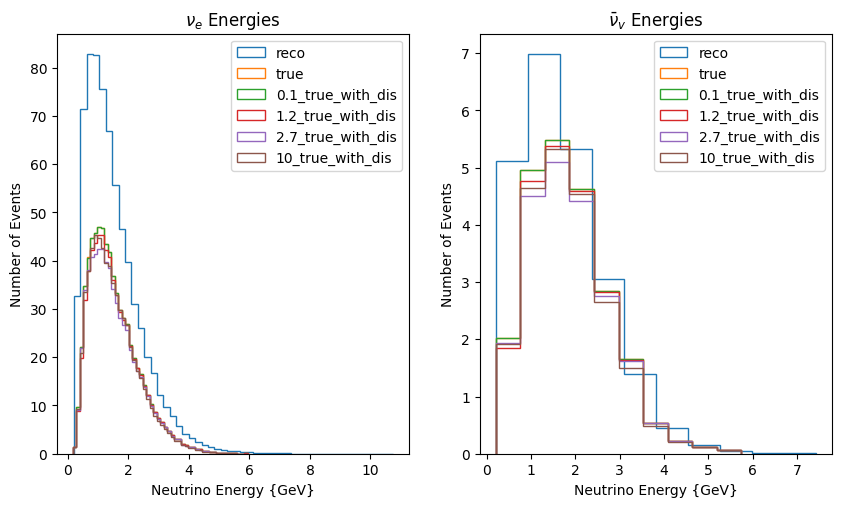

In [30]:
# Nue_Intrinsic plots
plt.figure(figsize=(10,12))

# no muon neutrinos in the intrinsic electron neutrinos file

plt.subplot(223)
plt.hist(Nue_Intrinsic["reco_energy"][(Nue_Intrinsic["nu_pdg"] == 12.0)], histtype="step", label="reco", bins=50, weights=Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == 12.0)])
plt.hist(Nue_Intrinsic["true_energy"][(Nue_Intrinsic["nu_pdg"] == 12.0)], histtype="step", label="true", bins=50, weights=Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == 12.0)])
plt.hist(Nue_Intrinsic["true_energy"][(Nue_Intrinsic["nu_pdg"] == 12.0)], histtype="step", label="0.1_true_with_dis", bins=50, weights=(Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == 12.0)])*(Nue_Intrinsic["ee_osc_0.1"][(Nue_Intrinsic["nu_pdg"] == 12.0)]))
plt.hist(Nue_Intrinsic["true_energy"][(Nue_Intrinsic["nu_pdg"] == 12.0)], histtype="step", label="1.2_true_with_dis", bins=50, weights=(Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == 12.0)])*(Nue_Intrinsic["ee_osc_1.2"][(Nue_Intrinsic["nu_pdg"] == 12.0)]))
plt.hist(Nue_Intrinsic["true_energy"][(Nue_Intrinsic["nu_pdg"] == 12.0)], histtype="step", label="2.7_true_with_dis", bins=50, weights=(Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == 12.0)])*(Nue_Intrinsic["ee_osc_2.7"][(Nue_Intrinsic["nu_pdg"] == 12.0)]))
plt.hist(Nue_Intrinsic["true_energy"][(Nue_Intrinsic["nu_pdg"] == 12.0)], histtype="step", label="10_true_with_dis", bins=50, weights=(Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == 12.0)])*(Nue_Intrinsic["ee_osc_10"][(Nue_Intrinsic["nu_pdg"] == 12.0)]))
plt.legend()
plt.title("$\\nu_{e}$ Energies")
plt.xlabel("Neutrino Energy {GeV}")
plt.ylabel("Number of Events")
#plt.text(2.5,900,"POT = 1.2e21")
                 
plt.subplot(224)
plt.hist(Nue_Intrinsic["reco_energy"][(Nue_Intrinsic["nu_pdg"] == -12.0)], histtype="step", label="reco", bins=10, weights=Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == -12.0)])
plt.hist(Nue_Intrinsic["true_energy"][(Nue_Intrinsic["nu_pdg"] == -12.0)], histtype="step", label="true", bins=10, weights=Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == -12.0)])
plt.hist(Nue_Intrinsic["true_energy"][(Nue_Intrinsic["nu_pdg"] == -12.0)], histtype="step", label="0.1_true_with_dis", bins=10, weights=(Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == -12.0)])*(Nue_Intrinsic["ee_osc_0.1"][(Nue_Intrinsic["nu_pdg"] == -12.0)]))
plt.hist(Nue_Intrinsic["true_energy"][(Nue_Intrinsic["nu_pdg"] == -12.0)], histtype="step", label="1.2_true_with_dis", bins=10, weights=(Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == -12.0)])*(Nue_Intrinsic["ee_osc_1.2"][(Nue_Intrinsic["nu_pdg"] == -12.0)]))
plt.hist(Nue_Intrinsic["true_energy"][(Nue_Intrinsic["nu_pdg"] == -12.0)], histtype="step", label="2.7_true_with_dis", bins=10, weights=(Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == -12.0)])*(Nue_Intrinsic["ee_osc_2.7"][(Nue_Intrinsic["nu_pdg"] == -12.0)]))
plt.hist(Nue_Intrinsic["true_energy"][(Nue_Intrinsic["nu_pdg"] == -12.0)], histtype="step", label="10_true_with_dis", bins=10, weights=(Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == -12.0)])*(Nue_Intrinsic["ee_osc_10"][(Nue_Intrinsic["nu_pdg"] == -12.0)]))
plt.legend()
plt.title("$\\bar{\\nu}_{v}$ Energies")
plt.xlabel("Neutrino Energy {GeV}")
plt.ylabel("Number of Events")
#plt.text(0.9,15.5,"POT = 1.2e21")

## this looks like not enough events, but that's becuase the final weights were very low for the intrinsic electrons

Text(0, 0.5, 'Number of Events')

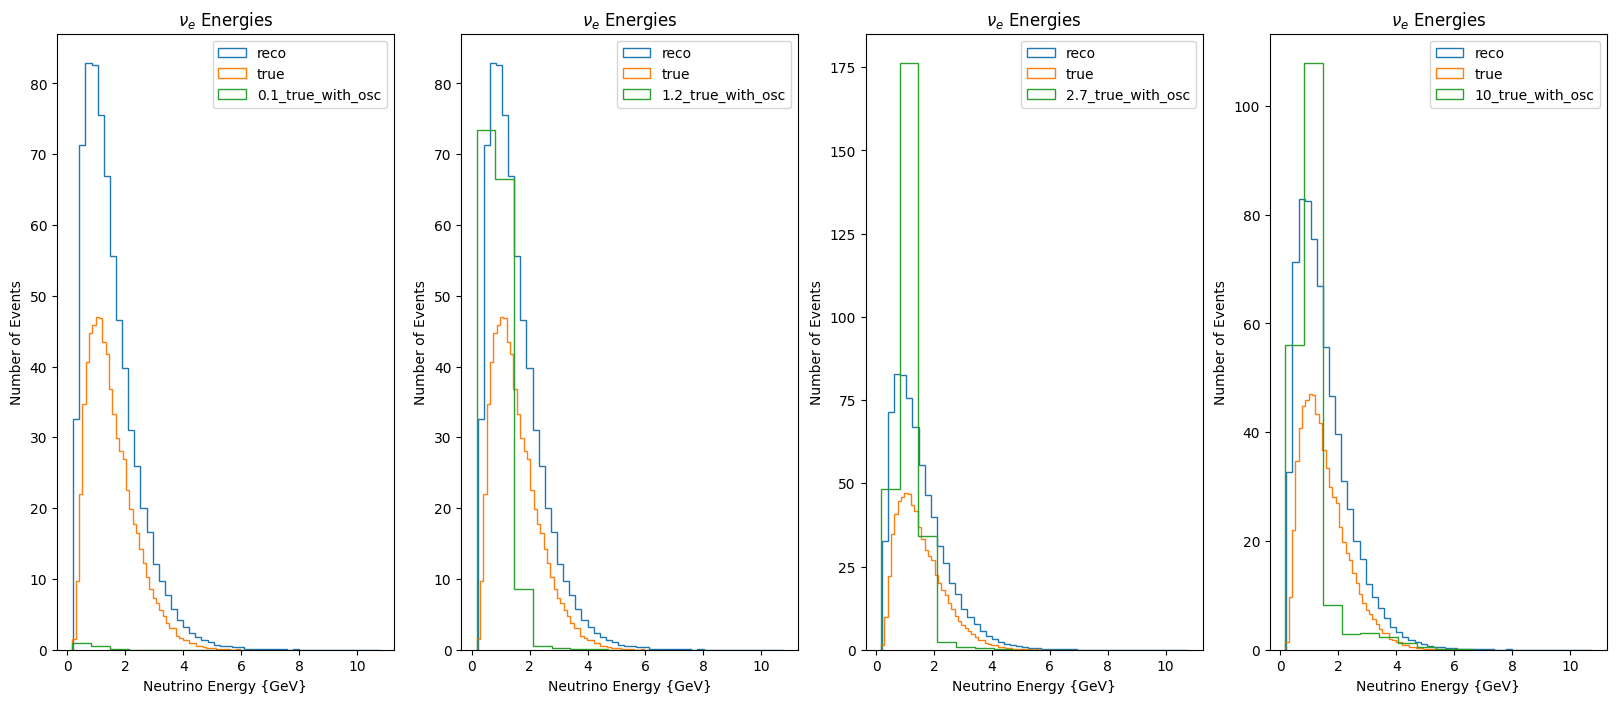

In [31]:
#combined histograms of nue:
#no losing nue, just intrinsic nue and appearance nue from (mu->e)
plt.figure(figsize=(20,8))

plt.subplot(141)
plt.hist(Nue_Intrinsic["reco_energy"][(Nue_Intrinsic["nu_pdg"] == 12.0)], histtype="step", label="reco", bins=50, weights=Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == 12.0)])
plt.hist(Nue_Intrinsic["true_energy"][(Nue_Intrinsic["nu_pdg"] == 12.0)], histtype="step", label="true", bins=50, weights=Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == 12.0)])
#plt.hist(Nue_Intrinsic["true_energy"][(Nue_Intrinsic["nu_pdg"] == 12.0)], histtype="step", label="0.1_true_with_dis", bins=50, weights=(Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == 12.0)])*(Nue_Intrinsic["ee_osc_0.1"][(Nue_Intrinsic["nu_pdg"] == 12.0)]))
#plt.hist(Nue_Intrinsic["true_energy"][(Nue_Intrinsic["nu_pdg"] == 12.0)], histtype="step", label="1.2_true_with_dis", bins=50, weights=(Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == 12.0)])*(Nue_Intrinsic["ee_osc_1.2"][(Nue_Intrinsic["nu_pdg"] == 12.0)]))
#plt.hist(Nue_Intrinsic["true_energy"][(Nue_Intrinsic["nu_pdg"] == 12.0)], histtype="step", label="2.7_true_with_dis", bins=50, weights=(Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == 12.0)])*(Nue_Intrinsic["ee_osc_2.7"][(Nue_Intrinsic["nu_pdg"] == 12.0)]))
#plt.hist(Nue_Intrinsic["true_energy"][(Nue_Intrinsic["nu_pdg"] == 12.0)], histtype="step", label="10_true_with_dis", bins=50, weights=(Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == 12.0)])*(Nue_Intrinsic["ee_osc_10"][(Nue_Intrinsic["nu_pdg"] == 12.0)]))
plt.hist(Nue_NuOsc["true_energy"][(Nue_NuOsc["nu_pdg"] == 12.0)], histtype="step", label="0.1_true_with_osc", bins=10, weights=(Nue_NuOsc["pot_weight"][(Nue_NuOsc["nu_pdg"] == 12.0)])*(Nue_NuOsc["mue_osc_0.1"][(Nue_NuOsc["nu_pdg"] == 12.0)]))


#plt.hist(Nue_NuOsc["true_energy"][(Nue_NuOsc["nu_pdg"] == 12.0)], histtype="barstacked", label="0.1_true_with_osc", bins=10, weights=(Nue_NuOsc["pot_weight"][(Nue_NuOsc["nu_pdg"] == 12.0)])*(Nue_NuOsc["mue_osc_0.1"][(Nue_NuOsc["nu_pdg"] == 12.0)]))
plt.legend()
plt.title("$\\nu_{e}$ Energies")
plt.xlabel("Neutrino Energy {GeV}")
plt.ylabel("Number of Events")

plt.subplot(142)
plt.hist(Nue_Intrinsic["reco_energy"][(Nue_Intrinsic["nu_pdg"] == 12.0)], histtype="step", label="reco", bins=50, weights=Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == 12.0)])
plt.hist(Nue_Intrinsic["true_energy"][(Nue_Intrinsic["nu_pdg"] == 12.0)], histtype="step", label="true", bins=50, weights=Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == 12.0)])
#plt.hist(Nue_Intrinsic["true_energy"][(Nue_Intrinsic["nu_pdg"] == 12.0)], histtype="step", label="0.1_true_with_dis", bins=50, weights=(Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == 12.0)])*(Nue_Intrinsic["ee_osc_0.1"][(Nue_Intrinsic["nu_pdg"] == 12.0)]))
#plt.hist(Nue_Intrinsic["true_energy"][(Nue_Intrinsic["nu_pdg"] == 12.0)], histtype="step", label="1.2_true_with_dis", bins=50, weights=(Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == 12.0)])*(Nue_Intrinsic["ee_osc_1.2"][(Nue_Intrinsic["nu_pdg"] == 12.0)]))
#plt.hist(Nue_Intrinsic["true_energy"][(Nue_Intrinsic["nu_pdg"] == 12.0)], histtype="step", label="2.7_true_with_dis", bins=50, weights=(Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == 12.0)])*(Nue_Intrinsic["ee_osc_2.7"][(Nue_Intrinsic["nu_pdg"] == 12.0)]))
#plt.hist(Nue_Intrinsic["true_energy"][(Nue_Intrinsic["nu_pdg"] == 12.0)], histtype="step", label="10_true_with_dis", bins=50, weights=(Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == 12.0)])*(Nue_Intrinsic["ee_osc_10"][(Nue_Intrinsic["nu_pdg"] == 12.0)]))
plt.hist(Nue_NuOsc["true_energy"][(Nue_NuOsc["nu_pdg"] == 12.0)], histtype="step", label="1.2_true_with_osc", bins=10, weights=(Nue_NuOsc["pot_weight"][(Nue_NuOsc["nu_pdg"] == 12.0)])*(Nue_NuOsc["mue_osc_1.2"][(Nue_NuOsc["nu_pdg"] == 12.0)]))
plt.legend()
plt.title("$\\nu_{e}$ Energies")
plt.xlabel("Neutrino Energy {GeV}")
plt.ylabel("Number of Events")

plt.subplot(143)
plt.hist(Nue_Intrinsic["reco_energy"][(Nue_Intrinsic["nu_pdg"] == 12.0)], histtype="step", label="reco", bins=50, weights=Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == 12.0)])
plt.hist(Nue_Intrinsic["true_energy"][(Nue_Intrinsic["nu_pdg"] == 12.0)], histtype="step", label="true", bins=50, weights=Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == 12.0)])
#plt.hist(Nue_Intrinsic["true_energy"][(Nue_Intrinsic["nu_pdg"] == 12.0)], histtype="step", label="0.1_true_with_dis", bins=50, weights=(Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == 12.0)])*(Nue_Intrinsic["ee_osc_0.1"][(Nue_Intrinsic["nu_pdg"] == 12.0)]))
#plt.hist(Nue_Intrinsic["true_energy"][(Nue_Intrinsic["nu_pdg"] == 12.0)], histtype="step", label="1.2_true_with_dis", bins=50, weights=(Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == 12.0)])*(Nue_Intrinsic["ee_osc_1.2"][(Nue_Intrinsic["nu_pdg"] == 12.0)]))
#plt.hist(Nue_Intrinsic["true_energy"][(Nue_Intrinsic["nu_pdg"] == 12.0)], histtype="step", label="2.7_true_with_dis", bins=50, weights=(Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == 12.0)])*(Nue_Intrinsic["ee_osc_2.7"][(Nue_Intrinsic["nu_pdg"] == 12.0)]))
#plt.hist(Nue_Intrinsic["true_energy"][(Nue_Intrinsic["nu_pdg"] == 12.0)], histtype="step", label="10_true_with_dis", bins=50, weights=(Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == 12.0)])*(Nue_Intrinsic["ee_osc_10"][(Nue_Intrinsic["nu_pdg"] == 12.0)]))
plt.hist(Nue_NuOsc["true_energy"][(Nue_NuOsc["nu_pdg"] == 12.0)], histtype="step", label="2.7_true_with_osc", bins=10, weights=(Nue_NuOsc["pot_weight"][(Nue_NuOsc["nu_pdg"] == 12.0)])*(Nue_NuOsc["mue_osc_2.7"][(Nue_NuOsc["nu_pdg"] == 12.0)]))
plt.legend()
plt.title("$\\nu_{e}$ Energies")
plt.xlabel("Neutrino Energy {GeV}")
plt.ylabel("Number of Events")

plt.subplot(144)
plt.hist(Nue_Intrinsic["reco_energy"][(Nue_Intrinsic["nu_pdg"] == 12.0)], histtype="step", label="reco", bins=50, weights=Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == 12.0)])
plt.hist(Nue_Intrinsic["true_energy"][(Nue_Intrinsic["nu_pdg"] == 12.0)], histtype="step", label="true", bins=50, weights=Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == 12.0)])
#plt.hist(Nue_Intrinsic["true_energy"][(Nue_Intrinsic["nu_pdg"] == 12.0)], histtype="step", label="0.1_true_with_dis", bins=50, weights=(Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == 12.0)])*(Nue_Intrinsic["ee_osc_0.1"][(Nue_Intrinsic["nu_pdg"] == 12.0)]))
#plt.hist(Nue_Intrinsic["true_energy"][(Nue_Intrinsic["nu_pdg"] == 12.0)], histtype="step", label="1.2_true_with_dis", bins=50, weights=(Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == 12.0)])*(Nue_Intrinsic["ee_osc_1.2"][(Nue_Intrinsic["nu_pdg"] == 12.0)]))
#plt.hist(Nue_Intrinsic["true_energy"][(Nue_Intrinsic["nu_pdg"] == 12.0)], histtype="step", label="2.7_true_with_dis", bins=50, weights=(Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == 12.0)])*(Nue_Intrinsic["ee_osc_2.7"][(Nue_Intrinsic["nu_pdg"] == 12.0)]))
#plt.hist(Nue_Intrinsic["true_energy"][(Nue_Intrinsic["nu_pdg"] == 12.0)], histtype="step", label="10_true_with_dis", bins=50, weights=(Nue_Intrinsic["pot_weight"][(Nue_Intrinsic["nu_pdg"] == 12.0)])*(Nue_Intrinsic["ee_osc_10"][(Nue_Intrinsic["nu_pdg"] == 12.0)]))
plt.hist(Nue_NuOsc["true_energy"][(Nue_NuOsc["nu_pdg"] == 12.0)], histtype="step", label="10_true_with_osc", bins=10, weights=(Nue_NuOsc["pot_weight"][(Nue_NuOsc["nu_pdg"] == 12.0)])*(Nue_NuOsc["mue_osc_10"][(Nue_NuOsc["nu_pdg"] == 12.0)]))
plt.legend()
plt.title("$\\nu_{e}$ Energies")
plt.xlabel("Neutrino Energy {GeV}")
plt.ylabel("Number of Events")



In [32]:
Nue_NuOsc

,reco_energy,true_energy,nu_pdg,true_baseline,weight,pot_weight,mue_osc_0.1,mue_osc_1.2,mue_osc_2.7,mue_osc_10
0,1.213114,1.496588,12.0,462.181458,0.8,0.805185,0.000005,0.000617,0.002280,0.001485
1,0.432837,0.525711,12.0,448.144012,0.8,0.805185,0.000035,0.002784,0.000141,0.002915
2,1.414220,1.549919,12.0,432.758240,0.8,0.805185,0.000004,0.000511,0.002006,0.000464
3,1.332612,1.510953,12.0,453.108093,0.8,0.805185,0.000004,0.000584,0.002200,0.001148
4,1.508633,1.862239,12.0,428.752655,0.8,0.805185,0.000003,0.000354,0.001512,0.000140
...,...,...,...,...,...,...,...,...,...,...
150684,0.569495,1.049381,12.0,470.279938,0.8,0.805185,0.000010,0.001195,0.002997,0.000933
150685,0.645647,0.725496,12.0,453.229614,0.8,0.805185,0.000019,0.001991,0.002123,0.002981
150686,1.218402,1.234121,12.0,436.140656,0.8,0.805185,0.000006,0.000789,0.002630,0.002852
150687,1.144119,0.975885,12.0,429.831512,0.8,0.805185,0.000009,0.001161,0.002989,0.001214


In [33]:
Nue_Intrinsic["0.1_weight"] = Nue_Intrinsic["pot_weight"] * Nue_Intrinsic["ee_osc_0.1"]
Nue_Intrinsic["1.2_weight"] = Nue_Intrinsic["pot_weight"] * Nue_Intrinsic["ee_osc_1.2"]
Nue_Intrinsic["2.7_weight"] = Nue_Intrinsic["pot_weight"] * Nue_Intrinsic["ee_osc_2.7"]
Nue_Intrinsic["10_weight"] = Nue_Intrinsic["pot_weight"] * Nue_Intrinsic["ee_osc_10"]
Nue_Intrinsic["type"] = "Intrinsic"

Nue_NuOsc["0.1_weight"] = Nue_NuOsc["pot_weight"] * Nue_NuOsc["mue_osc_0.1"]
Nue_NuOsc["1.2_weight"] = Nue_NuOsc["pot_weight"] * Nue_NuOsc["mue_osc_1.2"]
Nue_NuOsc["2.7_weight"] = Nue_NuOsc["pot_weight"] * Nue_NuOsc["mue_osc_2.7"]
Nue_NuOsc["10_weight"] = Nue_NuOsc["pot_weight"] * Nue_NuOsc["mue_osc_10"]
Nue_NuOsc["type"] = "Oscillation"

In [34]:
Nue_NuOsc

,reco_energy,true_energy,nu_pdg,true_baseline,weight,pot_weight,mue_osc_0.1,mue_osc_1.2,mue_osc_2.7,mue_osc_10,0.1_weight,1.2_weight,2.7_weight,10_weight,type
0,1.213114,1.496588,12.0,462.181458,0.8,0.805185,0.000005,0.000617,0.002280,0.001485,0.000004,0.000497,0.001836,0.001196,Oscillation
1,0.432837,0.525711,12.0,448.144012,0.8,0.805185,0.000035,0.002784,0.000141,0.002915,0.000028,0.002242,0.000114,0.002347,Oscillation
2,1.414220,1.549919,12.0,432.758240,0.8,0.805185,0.000004,0.000511,0.002006,0.000464,0.000003,0.000412,0.001615,0.000374,Oscillation
3,1.332612,1.510953,12.0,453.108093,0.8,0.805185,0.000004,0.000584,0.002200,0.001148,0.000004,0.000470,0.001772,0.000924,Oscillation
4,1.508633,1.862239,12.0,428.752655,0.8,0.805185,0.000003,0.000354,0.001512,0.000140,0.000002,0.000285,0.001218,0.000113,Oscillation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150684,0.569495,1.049381,12.0,470.279938,0.8,0.805185,0.000010,0.001195,0.002997,0.000933,0.000008,0.000962,0.002413,0.000751,Oscillation
150685,0.645647,0.725496,12.0,453.229614,0.8,0.805185,0.000019,0.001991,0.002123,0.002981,0.000015,0.001603,0.001709,0.002400,Oscillation
150686,1.218402,1.234121,12.0,436.140656,0.8,0.805185,0.000006,0.000789,0.002630,0.002852,0.000005,0.000636,0.002117,0.002296,Oscillation
150687,1.144119,0.975885,12.0,429.831512,0.8,0.805185,0.000009,0.001161,0.002989,0.001214,0.000008,0.000934,0.002407,0.000977,Oscillation


In [35]:
osc_e = Nue_NuOsc[["reco_energy","true_energy","nu_pdg","true_baseline","pot_weight","0.1_weight","1.2_weight","2.7_weight","10_weight","type"]][(Nue_NuOsc["nu_pdg"] == 12.0)]
osc_ae =  Nue_NuOsc[["reco_energy","true_energy","nu_pdg","true_baseline","pot_weight","0.1_weight","1.2_weight","2.7_weight","10_weight","type"]][(Nue_NuOsc["nu_pdg"] == -12.0)]

intrin_e = Nue_Intrinsic[["reco_energy","true_energy","nu_pdg","true_baseline","pot_weight","0.1_weight","1.2_weight","2.7_weight","10_weight","type"]][(Nue_Intrinsic["nu_pdg"] == 12.0)]
intrin_ae =  Nue_Intrinsic[["reco_energy","true_energy","nu_pdg","true_baseline","pot_weight","0.1_weight","1.2_weight","2.7_weight","10_weight","type"]][(Nue_Intrinsic["nu_pdg"] == -12.0)]

total_e = pd.concat([osc_e, intrin_e], axis=0)
total_ae = pd.concat([osc_ae, intrin_ae], axis=0)
total_e

,reco_energy,true_energy,nu_pdg,true_baseline,pot_weight,0.1_weight,1.2_weight,2.7_weight,10_weight,type
0,1.213114,1.496588,12.0,462.181458,0.805185,0.000004,0.000497,0.001836,0.001196,Oscillation
1,0.432837,0.525711,12.0,448.144012,0.805185,0.000028,0.002242,0.000114,0.002347,Oscillation
2,1.414220,1.549919,12.0,432.758240,0.805185,0.000003,0.000412,0.001615,0.000374,Oscillation
3,1.332612,1.510953,12.0,453.108093,0.805185,0.000004,0.000470,0.001772,0.000924,Oscillation
4,1.508633,1.862239,12.0,428.752655,0.805185,0.000002,0.000285,0.001218,0.000113,Oscillation
...,...,...,...,...,...,...,...,...,...,...
141977,1.214176,1.287920,12.0,461.427307,0.005147,0.005146,0.005008,0.004690,0.004646,Intrinsic
141978,0.391194,1.161591,12.0,439.463531,0.005147,0.005146,0.004994,0.004670,0.004637,Intrinsic
141979,0.914526,0.891304,12.0,424.930573,0.005147,0.005145,0.004920,0.004634,0.005121,Intrinsic
141980,2.312864,2.029602,12.0,455.294495,0.005147,0.005147,0.005089,0.004898,0.005104,Intrinsic


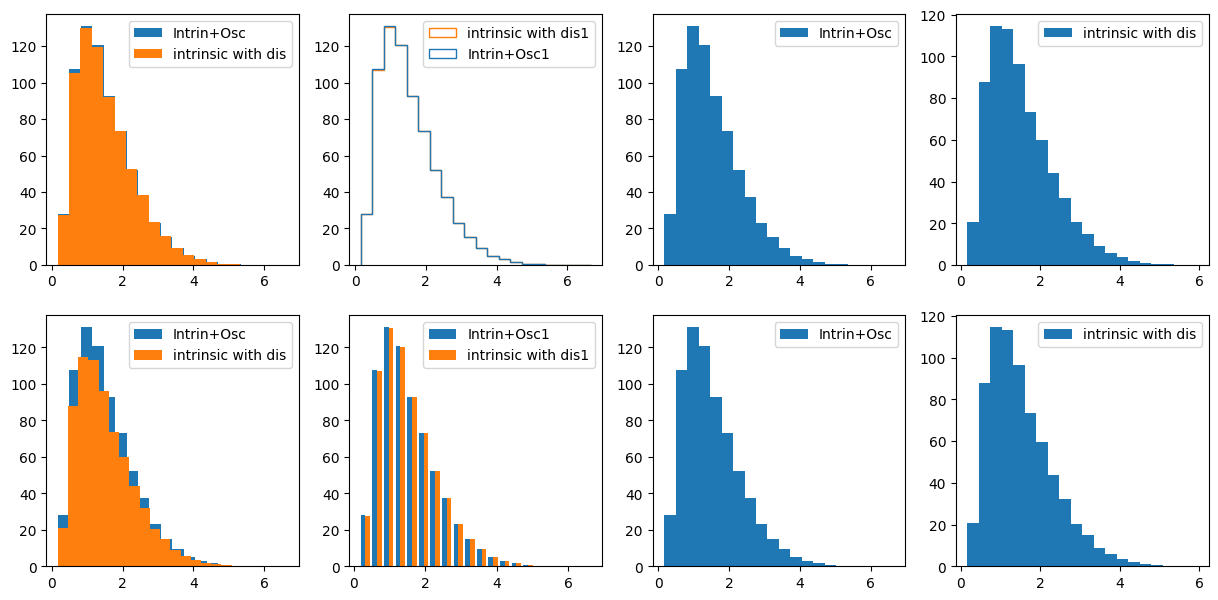

In [36]:
a = [total_e["true_energy"], total_e["true_energy"][(total_e["type"] == "Intrinsic")]]
b = [total_e["0.1_weight"], total_e["0.1_weight"][(total_e["type"] == "Intrinsic")]]

#the shapes dont line up between graps because the 2 datasets have different ranges, meaning different bin sizes

plt.figure(figsize=(15,15))

plt.subplot(441)
plt.hist(total_e["true_energy"], weights=total_e["0.1_weight"], bins=20, histtype="barstacked", label="Intrin+Osc")

#plt.hist([total_e["true_energy"], total_e["true_energy"][(total_e["type"] == "Intrinsic")]], weights=[total_e["0.1_weight"], total_e["0.1_weight"][(total_e["type"] == "Intrinsic")]], bins=20, histtype="step", label=["Intrin+Osc1", "intrinsic with dis1"])

plt.hist(total_e["true_energy"][(total_e["type"] == "Intrinsic")], bins=18, histtype="barstacked", weights = total_e["0.1_weight"][(total_e["type"] == "Intrinsic")], label="intrinsic with dis")
plt.legend()

plt.subplot(442)
plt.hist([total_e["true_energy"], total_e["true_energy"][(total_e["type"] == "Intrinsic")]], weights=[total_e["0.1_weight"], total_e["0.1_weight"][(total_e["type"] == "Intrinsic")]], bins=20, histtype="step", label=["Intrin+Osc1", "intrinsic with dis1"])
plt.legend()

plt.subplot(443)
plt.hist(total_e["true_energy"], weights=total_e["0.1_weight"], bins=20, histtype="barstacked", label="Intrin+Osc")
plt.legend()

plt.subplot(444)
plt.hist(total_e["true_energy"][(total_e["type"] == "Intrinsic")], bins=20, histtype="barstacked", weights = total_e["0.1_weight"][(total_e["type"] == "Intrinsic")], label="intrinsic with dis")
plt.legend()

plt.subplot(445)
plt.hist(a[0], weights=b[0], bins=20, histtype="barstacked", label="Intrin+Osc")

#plt.hist([total_e["true_energy"], total_e["true_energy"][(total_e["type"] == "Intrinsic")]], weights=[total_e["0.1_weight"], total_e["0.1_weight"][(total_e["type"] == "Intrinsic")]], bins=20, histtype="step", label=["Intrin+Osc1", "intrinsic with dis1"])

plt.hist(a[1], bins=20, histtype="barstacked", weights =b[1], label="intrinsic with dis")
plt.legend()

plt.subplot(446)
plt.hist(a, weights=b, bins=20, histtype="bar", label=["Intrin+Osc1", "intrinsic with dis1"])
plt.legend()

plt.subplot(447)
plt.hist(a[0], weights=b[0], bins=20, histtype="barstacked", label="Intrin+Osc")
plt.legend()

plt.subplot(448)
plt.hist(a[1], bins=20, histtype="barstacked", weights =b[1], label="intrinsic with dis")
plt.legend()

In [37]:
intrin_e

,reco_energy,true_energy,nu_pdg,true_baseline,pot_weight,0.1_weight,1.2_weight,2.7_weight,10_weight,type
0,0.923315,0.876059,12.0,440.938934,0.005147,0.005145,0.004899,0.004645,0.005141,Intrinsic
1,1.362947,1.371606,12.0,419.937988,0.005147,0.005146,0.005043,0.004760,0.004910,Intrinsic
2,0.767507,0.945759,12.0,456.666046,0.005147,0.005145,0.004915,0.004636,0.005135,Intrinsic
3,0.969170,1.224530,12.0,456.922424,0.005147,0.005146,0.004998,0.004675,0.004633,Intrinsic
4,1.053085,1.045812,12.0,424.669800,0.005147,0.005146,0.004974,0.004649,0.004728,Intrinsic
...,...,...,...,...,...,...,...,...,...,...
141977,1.214176,1.287920,12.0,461.427307,0.005147,0.005146,0.005008,0.004690,0.004646,Intrinsic
141978,0.391194,1.161591,12.0,439.463531,0.005147,0.005146,0.004994,0.004670,0.004637,Intrinsic
141979,0.914526,0.891304,12.0,424.930573,0.005147,0.005145,0.004920,0.004634,0.005121,Intrinsic
141980,2.312864,2.029602,12.0,455.294495,0.005147,0.005147,0.005089,0.004898,0.005104,Intrinsic


In [38]:
#try finding chi2 values for plots above

#if the expected count is 0, the sum goes to infinity, so just skip those boxes for right now
def chi2(expect, obs, distribution="poisson", dof_normalize=False, subtract_from_dof=0):
    diff = expect - obs
    diff2 = diff**2
    
    if (distribution=="poisson"):
        diff3 = diff2/expect
        
    #elif (_______):
        # change the sigma/uncertainty based off of different expected distributions and fits
        # maybe also change the expected values? but that's less certain as the expected is currently just the intrinsic counts
        #   
        
    chi2 =0
    n = 0
    for i in diff3:
        n = n+1
        if (np.isinf(i)):
            continue
        chi2 = chi2 + i

    if(dof_normalize):
        dof = n - subtract_from_dof
        chi2 = chi2/dof
        return chi2
    else:
        return chi2


In [39]:
#test my chi2 function
expect = np.array([1,1,3,1])
obs = np.array([1,1,1,0])

chi2(expect,obs)

2.333333333333333

/tmp/ipykernel_406280/1593093474.py:9: RuntimeWarning: divide by zero encountered in divide
  diff3 = diff2/expect


Text(0.5, 1.0, 'Intrinsic and Oscillated $\\bar{\\nu}_e$ at $\\Delta{m}^2=10$ \n$\\chi^2=$0.08149')

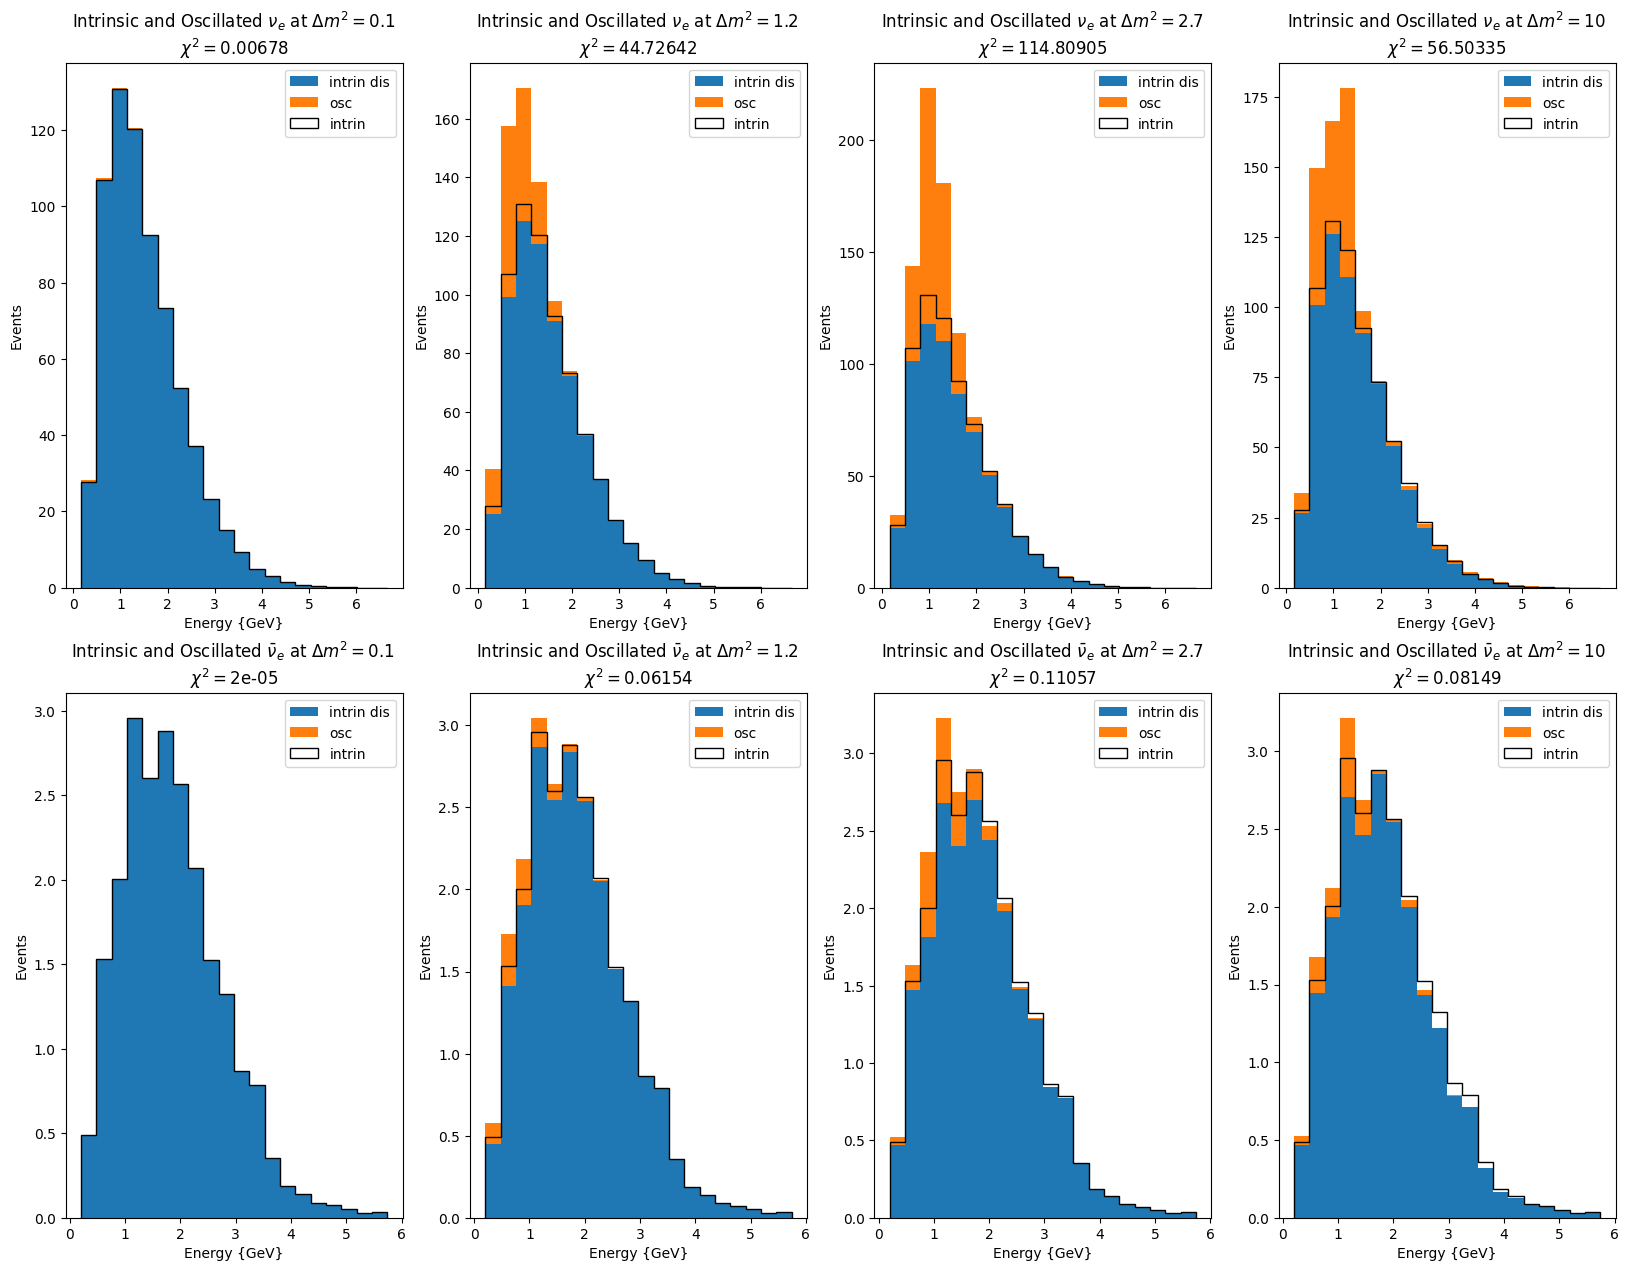

In [40]:
# when the histogram is barstacked, the frequency counts return does NOT do the 2 seperate colors
#instead, it does the lower color, and then the COMBINED 2 color counts
#to get the 2nd color, subtract the 2 arrays
t = "barstacked"
chi2s = []

plt.figure(figsize=(20,15))

#plot 1
plt.subplot(241)
z0 = plt.hist([intrin_e["true_energy"], osc_e["true_energy"]], bins=20, histtype=t, label=["intrin dis","osc"], weights=[intrin_e["0.1_weight"],osc_e["0.1_weight"]])
i0 = plt.hist(intrin_e["true_energy"], bins=z0[1], color="black", histtype="step", label="intrin", weights=intrin_e["pot_weight"])
chi2s.append(chi2(i0[0], z0[0][1]))

plt.legend()
plt.ylabel("Events")
plt.xlabel("Energy {GeV}")
plt.title("Intrinsic and Oscillated $\\nu_e$ at $\Delta{m}^2=0.1$ \n$\\chi^2=$" + str(round(chi2s[0],5)))

#plot 2
plt.subplot(242)
z1 = plt.hist([intrin_e["true_energy"], osc_e["true_energy"]], bins=20, histtype=t, label=["intrin dis","osc"], weights=[intrin_e["1.2_weight"],osc_e["1.2_weight"]])
i1 = plt.hist(intrin_e["true_energy"], bins=z1[1], color="black", histtype="step", label="intrin", weights=intrin_e["pot_weight"])
chi2s.append(chi2(i1[0], z1[0][1]))

plt.legend()
plt.ylabel("Events")
plt.xlabel("Energy {GeV}")
plt.title("Intrinsic and Oscillated $\\nu_e$ at $\Delta{m}^2=1.2$ \n$\\chi^2=$" + str(round(chi2s[1],5)))

#plot 3
plt.subplot(243)
z2 = plt.hist([intrin_e["true_energy"], osc_e["true_energy"]], bins=20, histtype=t, label=["intrin dis","osc"], weights=[intrin_e["2.7_weight"],osc_e["2.7_weight"]])
i2 = plt.hist(intrin_e["true_energy"], bins=z2[1], color="black", histtype="step", label="intrin", weights=intrin_e["pot_weight"])
chi2s.append(chi2(i2[0], z2[0][1]))

plt.legend()
plt.ylabel("Events")
plt.xlabel("Energy {GeV}")
plt.title("Intrinsic and Oscillated $\\nu_e$ at $\Delta{m}^2=2.7$ \n$\\chi^2=$" + str(round(chi2s[2],5)))

#plot 4
plt.subplot(244)
z3 = plt.hist([intrin_e["true_energy"], osc_e["true_energy"]], bins=20, histtype=t, label=["intrin dis","osc"], weights=[intrin_e["10_weight"],osc_e["10_weight"]])
i3 = plt.hist(intrin_e["true_energy"], bins=z3[1], color="black", histtype="step", label="intrin", weights=intrin_e["pot_weight"])
chi2s.append(chi2(i3[0], z3[0][1]))

plt.legend()
plt.ylabel("Events")
plt.xlabel("Energy {GeV}")
plt.title("Intrinsic and Oscillated $\\nu_e$ at $\Delta{m}^2=10$ \n$\\chi^2=$" + str(round(chi2s[3],5)))

#plot 5
plt.subplot(245)
z4 = plt.hist([intrin_ae["true_energy"], osc_ae["true_energy"]], bins=20, histtype=t, label=["intrin dis","osc"], weights=[intrin_ae["0.1_weight"],osc_ae["0.1_weight"]])
i4 = plt.hist(intrin_ae["true_energy"], bins=z4[1], color="black", histtype="step", label="intrin", weights=intrin_ae["pot_weight"])
chi2s.append(chi2(i4[0], z4[0][1]))

plt.legend()
plt.ylabel("Events")
plt.xlabel("Energy {GeV}")
plt.title("Intrinsic and Oscillated $\\bar{\\nu}_e$ at $\Delta{m}^2=0.1$ \n$\\chi^2=$" + str(round(chi2s[4],5)))

#plot 6
plt.subplot(246)
z5 = plt.hist([intrin_ae["true_energy"], osc_ae["true_energy"]], bins=20, histtype=t, label=["intrin dis","osc"], weights=[intrin_ae["1.2_weight"],osc_ae["1.2_weight"]])
i5 = plt.hist(intrin_ae["true_energy"], bins=z5[1], color="black", histtype="step", label="intrin", weights=intrin_ae["pot_weight"])
chi2s.append(chi2(i5[0], z5[0][1]))

plt.legend()
plt.ylabel("Events")
plt.xlabel("Energy {GeV}")
plt.title("Intrinsic and Oscillated $\\bar{\\nu}_e$ at $\Delta{m}^2=1.2$ \n$\\chi^2=$" + str(round(chi2s[5],5)))

#plot 7
plt.subplot(247)
z6 = plt.hist([intrin_ae["true_energy"], osc_ae["true_energy"]], bins=20, histtype=t, label=["intrin dis","osc"], weights=[intrin_ae["2.7_weight"],osc_ae["2.7_weight"]])
i6 = plt.hist(intrin_ae["true_energy"], bins=z6[1], color="black", histtype="step", label="intrin", weights=intrin_ae["pot_weight"])
chi2s.append(chi2(i6[0], z6[0][1]))

plt.legend()
plt.ylabel("Events")
plt.xlabel("Energy {GeV}")
plt.title("Intrinsic and Oscillated $\\bar{\\nu}_e$ at $\Delta{m}^2=2.7$ \n$\\chi^2=$" + str(round(chi2s[6],5)))

#plot 8
plt.subplot(248)
z7 = plt.hist([intrin_ae["true_energy"], osc_ae["true_energy"]], bins=20, histtype=t, label=["intrin dis","osc"], weights=[intrin_ae["10_weight"],osc_ae["10_weight"]])
i7 = plt.hist(intrin_ae["true_energy"], bins=z7[1], color="black", histtype="step", label="intrin", weights=intrin_ae["pot_weight"])
chi2s.append(chi2(i7[0], z7[0][1]))

plt.legend()
plt.ylabel("Events")
plt.xlabel("Energy {GeV}")
plt.title("Intrinsic and Oscillated $\\bar{\\nu}_e$ at $\Delta{m}^2=10$ \n$\\chi^2=$" + str(round(chi2s[7],5)))


In [41]:
osc_e["L/E"] = (osc_e["true_baseline"]/1000)/osc_e["true_energy"]
osc_ae["L/E"] = (osc_ae["true_baseline"]/1000)/osc_ae["true_energy"]
osc_e

,reco_energy,true_energy,nu_pdg,true_baseline,pot_weight,0.1_weight,1.2_weight,2.7_weight,10_weight,type,L/E
0,1.213114,1.496588,12.0,462.181458,0.805185,0.000004,0.000497,0.001836,0.001196,Oscillation,0.308824
1,0.432837,0.525711,12.0,448.144012,0.805185,0.000028,0.002242,0.000114,0.002347,Oscillation,0.852454
2,1.414220,1.549919,12.0,432.758240,0.805185,0.000003,0.000412,0.001615,0.000374,Oscillation,0.279214
3,1.332612,1.510953,12.0,453.108093,0.805185,0.000004,0.000470,0.001772,0.000924,Oscillation,0.299882
4,1.508633,1.862239,12.0,428.752655,0.805185,0.000002,0.000285,0.001218,0.000113,Oscillation,0.230235
...,...,...,...,...,...,...,...,...,...,...,...
150684,0.569495,1.049381,12.0,470.279938,0.805185,0.000008,0.000962,0.002413,0.000751,Oscillation,0.448150
150685,0.645647,0.725496,12.0,453.229614,0.805185,0.000015,0.001603,0.001709,0.002400,Oscillation,0.624717
150686,1.218402,1.234121,12.0,436.140656,0.805185,0.000005,0.000636,0.002117,0.002296,Oscillation,0.353402
150687,1.144119,0.975885,12.0,429.831512,0.805185,0.000008,0.000934,0.002407,0.000977,Oscillation,0.440453


Text(0.5, 1.0, 'Total and Oscillated $\\bar{\\nu}_{\\mu}$ at $\\Delta{m}^2=10$')

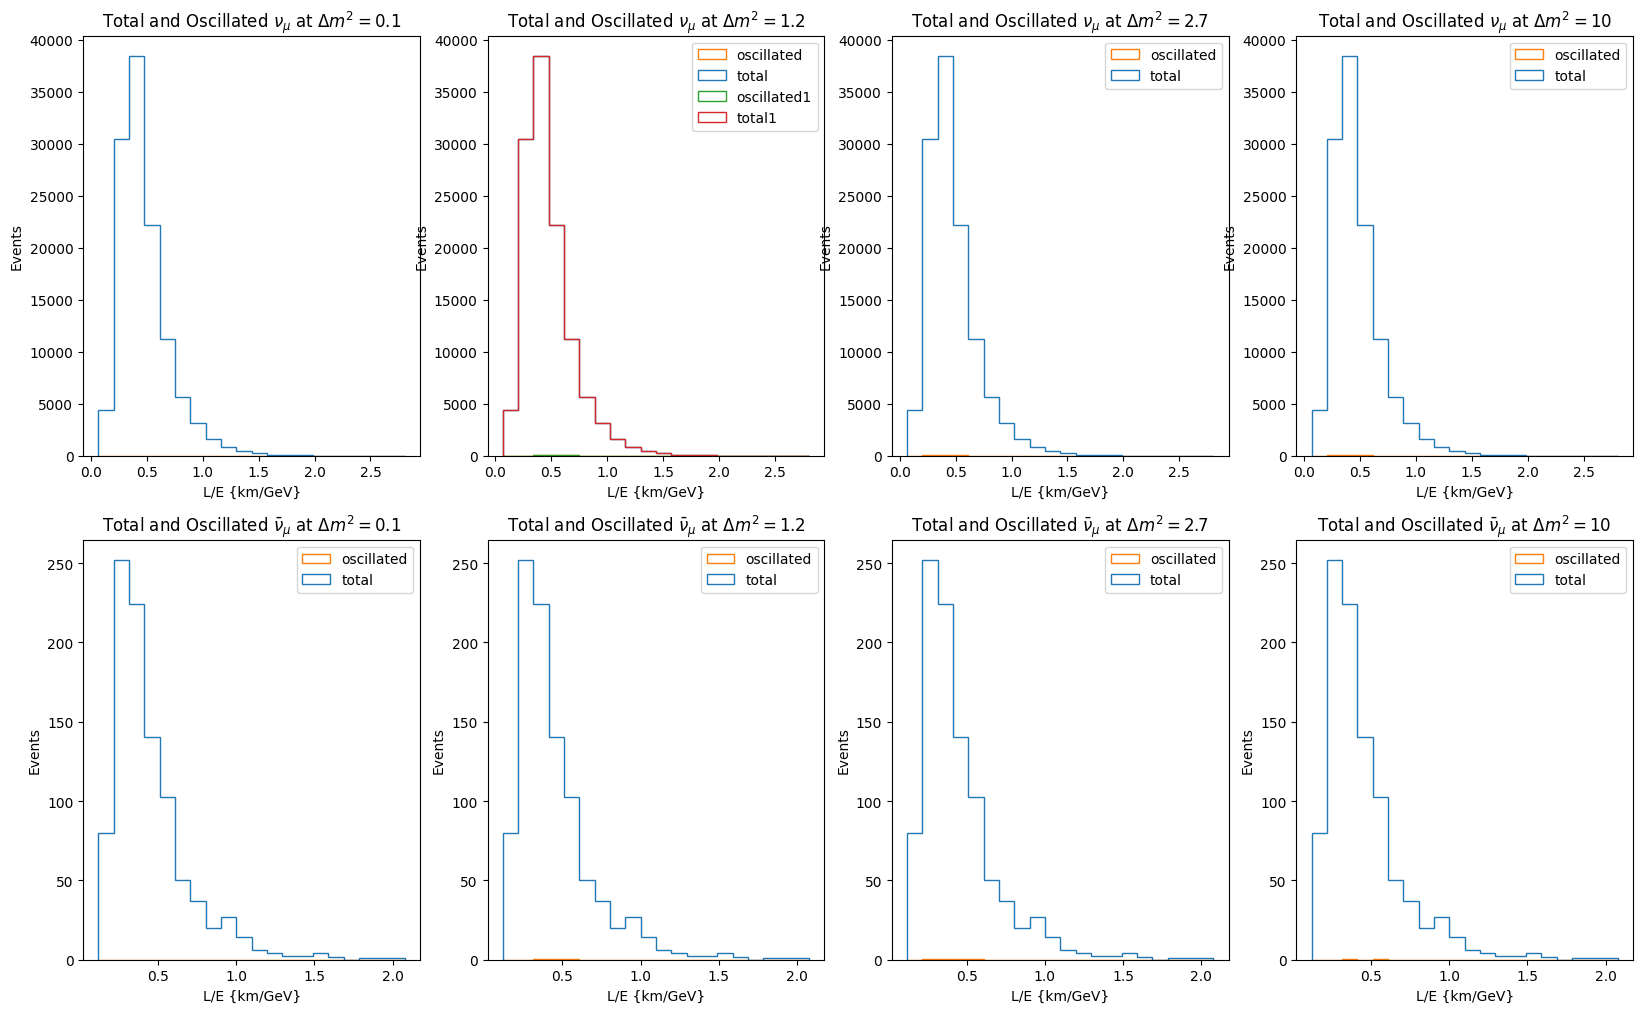

In [42]:
# look at oscillated vs unoscillated numu from nue_nuOsc list:
# this is assuming the nue_nuosc data set (which is in nue) is analogous to the total number of numu that could oscilate
t = "barstacked"

plt.figure(figsize=(20,12))

plt.subplot(241)
freq_01e = plt.hist([osc_e["L/E"], osc_e["L/E"]], bins=20, histtype="step", label=["total","oscillated"], weights=[osc_e["pot_weight"],osc_e["0.1_weight"]])
plt.legend
plt.ylabel("Events")
plt.xlabel("L/E {km/GeV}")
plt.title("Total and Oscillated $\\nu_{\\mu}$ at $\Delta{m}^2=0.1$")

plt.subplot(242)
freq_12e = plt.hist([osc_e["L/E"], osc_e["L/E"]], bins=20, histtype="step", label=["total","oscillated"], weights=[osc_e["pot_weight"],osc_e["1.2_weight"]])
fosc = plt.hist(osc_e["L/E"], bins=20, histtype="step", label="oscillated1", weights=osc_e["1.2_weight"])
ftotal = plt.hist(osc_e["L/E"], bins=20, histtype="step", label="total1", weights=osc_e["pot_weight"])
plt.legend()
plt.ylabel("Events")
plt.xlabel("L/E {km/GeV}")
plt.title("Total and Oscillated $\\nu_{\\mu}$ at $\Delta{m}^2=1.2$")

plt.subplot(243)
freq_27e = plt.hist([osc_e["L/E"], osc_e["L/E"]], bins=20, histtype="step", label=["total","oscillated"], weights=[osc_e["pot_weight"],osc_e["2.7_weight"]])
plt.legend()
plt.ylabel("Events")
plt.xlabel("L/E {km/GeV}")
plt.title("Total and Oscillated $\\nu_{\\mu}$ at $\Delta{m}^2=2.7$")

plt.subplot(244)
freq_10e = plt.hist([osc_e["L/E"], osc_e["L/E"]], bins=20, histtype="step", label=["total","oscillated"], weights=[osc_e["pot_weight"],osc_e["10_weight"]])
plt.legend()
plt.ylabel("Events")
plt.xlabel("L/E {km/GeV}")
plt.title("Total and Oscillated $\\nu_{\\mu}$ at $\Delta{m}^2=10$")

plt.subplot(245)
freq_01ae = plt.hist([osc_ae["L/E"], osc_ae["L/E"]], bins=20, histtype="step", label=["total","oscillated"], weights=[osc_ae["pot_weight"],osc_ae["0.1_weight"]])
plt.legend()
plt.ylabel("Events")
plt.xlabel("L/E {km/GeV}")
plt.title("Total and Oscillated $\\bar{\\nu}_{\\mu}$ at $\Delta{m}^2=0.1$")

plt.subplot(246)
freq_12ae = plt.hist([osc_ae["L/E"], osc_ae["L/E"]], bins=20, histtype="step", label=["total","oscillated"], weights=[osc_ae["pot_weight"],osc_ae["1.2_weight"]])
plt.legend()
plt.ylabel("Events")
plt.xlabel("L/E {km/GeV}")
plt.title("Total and Oscillated $\\bar{\\nu}_{\\mu}$ at $\Delta{m}^2=1.2$")

plt.subplot(247)
freq_27ae = plt.hist([osc_ae["L/E"], osc_ae["L/E"]], bins=20, histtype="step", label=["total","oscillated"], weights=[osc_ae["pot_weight"],osc_ae["2.7_weight"]])
plt.legend()
plt.ylabel("Events")
plt.xlabel("L/E {km/GeV}")
plt.title("Total and Oscillated $\\bar{\\nu}_{\\mu}$ at $\Delta{m}^2=2.7$")

plt.subplot(248)
freq_10ae = plt.hist([osc_ae["L/E"], osc_ae["L/E"]], bins=20, histtype="step", label=["total","oscillated"], weights=[osc_ae["pot_weight"],osc_ae["10_weight"]])
plt.legend()
plt.ylabel("Events")
plt.xlabel("L/E {km/GeV}")
plt.title("Total and Oscillated $\\bar{\\nu}_{\\mu}$ at $\Delta{m}^2=10$")


In [43]:
#grab the frequency ratio and average L/E's for each deltam2
# when the histograms are step plots, each frequency array is for the seperate data sets

aa = freq_01e[0][1] / freq_01e[0][0]
bb = freq_12e[0][1] / freq_12e[0][0]
cc = freq_27e[0][1] / freq_27e[0][0]
dd = freq_10e[0][1] / freq_10e[0][0]

ee = freq_01ae[0][1] / freq_01ae[0][0]
ee[16]=0
ff = freq_12ae[0][1] / freq_12ae[0][0]
ff[16]=0
gg = freq_27ae[0][1] / freq_27ae[0][0]
gg[16]=0
hh = freq_10ae[0][1] / freq_10ae[0][0]
hh[16]=0

/tmp/ipykernel_406280/3227176779.py:9: RuntimeWarning: invalid value encountered in divide
  ee = freq_01ae[0][1] / freq_01ae[0][0]
/tmp/ipykernel_406280/3227176779.py:11: RuntimeWarning: invalid value encountered in divide
  ff = freq_12ae[0][1] / freq_12ae[0][0]
/tmp/ipykernel_406280/3227176779.py:13: RuntimeWarning: invalid value encountered in divide
  gg = freq_27ae[0][1] / freq_27ae[0][0]
/tmp/ipykernel_406280/3227176779.py:15: RuntimeWarning: invalid value encountered in divide
  hh = freq_10ae[0][1] / freq_10ae[0][0]


In [44]:
aaa = np.zeros(20)
bbb = np.zeros(20)
ccc = np.zeros(20)
ddd = np.zeros(20)

eee = np.zeros(20)
fff = np.zeros(20)
ggg = np.zeros(20)
hhh = np.zeros(20)

for i in range(20):
    av = freq_01e[1][i] + freq_01e[1][i+1]
    aaa[i] = av/2
    
    bv = freq_12e[1][i] + freq_12e[1][i+1]
    bbb[i] = bv/2
    
    cv = freq_27e[1][i] + freq_27e[1][i+1]
    ccc[i] = cv/2
    
    dv = freq_10e[1][i] + freq_10e[1][i+1]
    ddd[i] = dv/2
    
    ev = freq_01ae[1][i] + freq_01ae[1][i+1]
    eee[i] = ev/2
    
    fv = freq_12ae[1][i] + freq_12ae[1][i+1]
    fff[i] = fv/2
    
    gv = freq_27ae[1][i] + freq_27ae[1][i+1]
    ggg[i] = gv/2
    
    hv = freq_10ae[1][i] + freq_10ae[1][i+1]
    hhh[i] = hv/2
    
    
aaa

array([0.13467969, 0.2717225 , 0.40876531, 0.54580812, 0.68285092,
       0.81989373, 0.95693654, 1.09397935, 1.23102215, 1.36806496,
       1.50510777, 1.64215058, 1.77919339, 1.91623619, 2.053279  ,
       2.19032181, 2.32736462, 2.46440742, 2.60145023, 2.73849304])

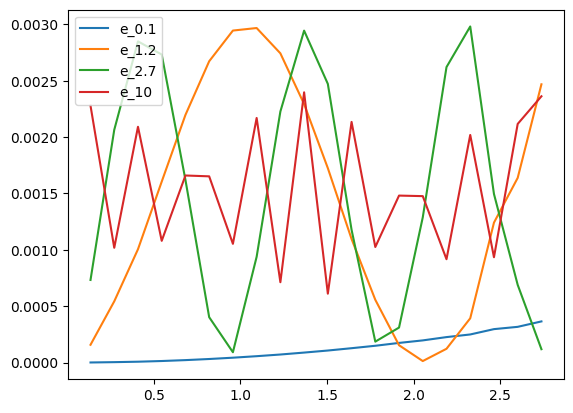

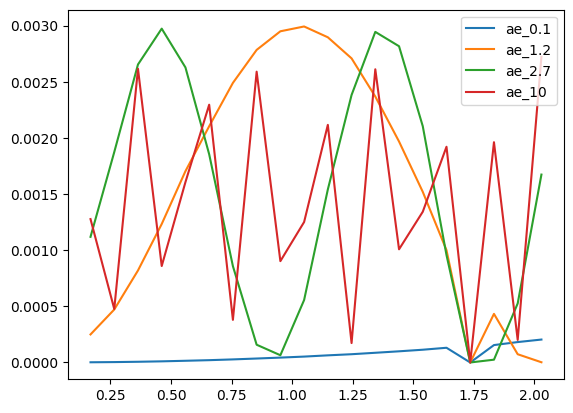

In [45]:
plt.plot(aaa, aa, label="e_0.1")
plt.plot(bbb,bb, label="e_1.2")
plt.plot(ccc,cc,label="e_2.7")
plt.plot(ddd,dd,label="e_10")
plt.legend()
plt.show()

plt.plot(eee,ee,label="ae_0.1")
plt.plot(fff,ff,label="ae_1.2")
plt.plot(ggg,gg,label="ae_2.7")
plt.plot(hhh,hh,label="ae_10")
plt.legend()
plt.show()